In [1]:
import pandas as pd
import numpy as np
import sys
import json 
import random
import math
import collections
import seaborn as sns
import networkx as nx
#!{sys.executable} -m pip install python-igraph
#!{sys.executable} -m pip install igraph
from collections import defaultdict
from scipy.stats.stats import pearsonr

from matplotlib import pyplot as plt
#!{sys.executable} -m pip install cdlib


import cdlib
from cdlib import algorithms as cd
from cdlib import readwrite, viz, evaluation

In [3]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from sklearn import preprocessing

# Static Community Discovery
## Preparation

In [ ]:
G = nx.read_weighted_edgelist('../../data/tuscanyJ_backboned.weighted.edgelist',delimiter=',')
len(G.nodes)

In [ ]:

weights = [G.edges[edge]['weight'] for edge in G.edges()]
maxW = max(weights) 
for edge in G.edges():
     G.edges[edge]['dissimilarity'] = 10000 - G.edges[edge]['weight']
    #G.edges[edge]['dissimilarity'] =  maxW+1 - G.edges[edge]['weight']

In [ ]:
components =  [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
avg_size = np.average([len(c) for c in components[1:]])
print('average componets size: ', avg_size)
print(len(components))
print([len(c) for c in components[:20]],'etc...')

C = G.subgraph(components[0]).copy()


In [ ]:
import pandas as pd
df = pd.read_csv("../data/geotuscany.csv",index_col=0)

#for node in C.nodes():
  #  C.nodes[node]['name'] = df.loc[int(node),'name']
    
df.head()

In [13]:
for i in  df[(df.latitude.isna()) | (df.longitude.isna())].index:
    prov = df.loc[i,'province']
    df.loc[i,'latitude'] = np.mean(df.loc[(~df.latitude.isna()) & (df.province == prov),'latitude'])
    df.loc[i,'longitude'] = np.mean(df.loc[(~df.longitude.isna()) & (df.province == prov),'longitude']) 

In [14]:
df = df.loc[[int(node) for node in C.nodes]].copy()
print(len(df))

15485


In [15]:
df.reset_index(inplace=True)
index_map = {str(old):new for new,old in df['index'].items()}
G = nx.relabel_nodes(C, index_map) 
for node in G.nodes: G.nodes[node]['province'] = df.loc[node,'province']

In [16]:
df.to_csv('../data/connenctedJ.csv')
nx.write_weighted_edgelist(G,'../data/connectedJ.weighted.edgelist')

## Data Loading

In [2]:
G = nx.read_weighted_edgelist('../data/connectedJ.weighted.edgelist')
G = nx.relabel_nodes(G, {node:int(node) for node in G.nodes}) 
df = pd.read_csv('../data/connenctedJ.csv',index_col=0)
for node in G.nodes:
    G.nodes[node]['province'] = df.loc[node,'province']

weights = [G.edges[edge]['weight'] for edge in G.edges()]
maxW = max(weights) 
for edge in G.edges():
    G.edges[edge]['dissimilarity'] = 10001 - G.edges[edge]['weight']
    #G.edges[edge]['dissimilarity'] =  maxW+1 - G.edges[edge]['weight']
    
df.head()

,index,position,name,city,menu,link,score,N_reviews,price,Name,...,latitude,longitude,cuisines,meals,specialDiets,positionlink,province,Link,provinceOK,longitud§e
0,0,2018,Osteria al Borgo,Lucca,False,/Restaurant_Review-g187898-d23137800-Reviews-O...,5.0,6,NaN,Osteria al Borgo,...,43.851808,10.506207,"Pizza, Tuscan, Central-Italian",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",j39_https://maps.google.com/maps?saddr=&daddr=...,pisa,/Restaurant_Review-g187898-d23137800-Reviews-O...,0,10.495633
1,12,1309,Il Genio Italiano,Florence,True,/Restaurant_Review-g187895-d2483611-Reviews-Il...,4.0,229,2.5,Il Genio Italiano,...,43.798058,11.219482,"Italian, Pizza, Mediterranean, Tuscan, Central...",NaN,Vegetarian Friendly,vs1_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2483611-Reviews-Il...,1,NaN
2,3,1285,La Locanda di Bivigliano,Bivigliano,False,/Restaurant_Review-g1957776-d13948598-Reviews-...,NaN,28,NaN,La Locanda di Bivigliano,...,43.893859,11.322421,"Italian, Mediterranean, Barbecue, Tuscan, Cent...",NaN,Vegetarian Friendly,rg1_https://maps.google.com/maps?saddr=&daddr=...,prato,/Restaurant_Review-g1957776-d13948598-Reviews-...,0,NaN
3,15,1330,Blend,Sesto Fiorentino,True,/Restaurant_Review-g194916-d12955635-Reviews-B...,4.0,198,2.5,Blend,...,43.830860,11.206403,"Italian, Pizza, Mediterranean, Barbecue","Dinner, Lunch","Vegetarian Friendly, Gluten Free Options",8SH_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g194916-d12955635-Reviews-B...,1,NaN
4,37,1316,La Taverna,Scandicci,False,/Restaurant_Review-g644284-d2660933-Reviews-La...,4.0,236,2.5,La Taverna,...,43.764280,11.180183,"Italian, Pizza, Seafood, Mediterranean",NaN,Vegetarian Friendly,zhJ_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g644284-d2660933-Reviews-La...,1,NaN


In [3]:
def assign(g,communities, attribute, overlap=False):
    
    if ~overlap:
        
        for label, community in enumerate(communities.communities):
            for node in community:
                g.nodes[node][attribute] = label
                
    else: 
        
        for node in g.nodes:
            g.nodes[node][attribute] = list()
            
        for label, community in enumerate(communities.communities):
            g.nodes[node][attribute].append(label)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

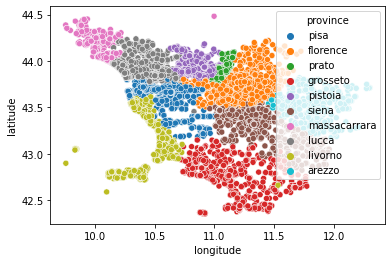

In [13]:
sns.scatterplot(data = df, x='longitude',y='latitude',hue='province')

In [14]:
provincemapping = {e:i for i,e in enumerate(df.province.unique())}

In [15]:
provinces =  {"communities":[[] for _ in df['province'].unique()]}
for i, c in df['province'].items():
    provinces['communities'][provincemapping[c]].append(i)
   
provinces["algorithm"] = 'provinces'
provinces["params"] =  {"initial_membership": None, "weights": None}
provinces["overlap"] = False
provinces["coverage"]= 1.0
with open('../data/communities/provinces.json','w+') as jf:
    json.dump(provinces, jf)


## Crisp Communities

### K means 
Use longitude and latitude

In [24]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(df[['latitude','longitude']])
print(pd.Series(kmeans.labels_).value_counts())

1    3599
6    2548
2    2045
9    1712
4    1135
3    1115
0    1069
7    1055
5     759
8     448
dtype: int64


In [25]:
df['kmeans'] = kmeans.labels_.astype(str)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

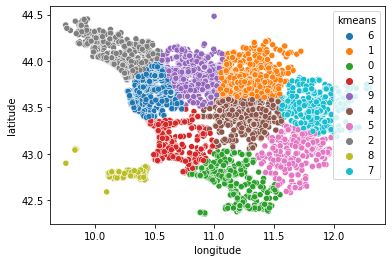

In [26]:
sns.scatterplot(data = df, x='longitude',y='latitude',hue='kmeans')

In [27]:
data = {"communities":[[] for _ in df['kmeans'].unique()]}
for i, c in df['kmeans'].items():
    data['communities'][int(c)].append(i)
  
data["algorithm"] = 'kmeans'
data["params"] =  {"initial_membership": None, "weights": None}
data["overlap"] = False
data["coverage"]= 1.0
with open('../data/communities/kmeans.json','w+') as jf:
    json.dump(data, jf)

    


In [28]:
for node in G.nodes:
    G.nodes[node]['kmeans'] = df.loc[node,'kmeans']

### Louvain

In [30]:
louvain = cd.louvain(G, resolution=1,weight='dissimilarity')
print(len(louvain.communities),[len(c) for c in louvain.communities ])


17 [2463, 2409, 1894, 1847, 1839, 1336, 1225, 877, 537, 455, 389, 165, 20, 11, 11, 6, 1]


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

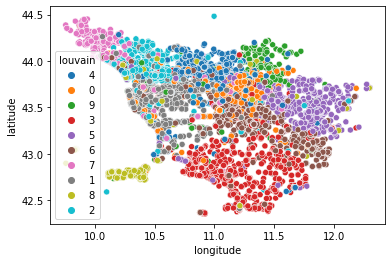

In [31]:
readwrite.write_community_json(louvain,'../data/communities/louvain.json')
assign(G,louvain,'louvain')
for node in G.nodes:
    df.loc[node,'louvain'] = str(G.nodes[node]['louvain'])

sns.scatterplot(data = df[df.louvain.astype(int)<10], x='longitude',y='latitude',hue='louvain')

### multicore

In [16]:
multicore = cd.multicore(G,alfa=0.9,weight='dissimilarity',minsize = 500)

In [17]:
[len(c) for c in multicore.communities]

[2982, 2836, 2706, 2486, 2285, 2190]

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

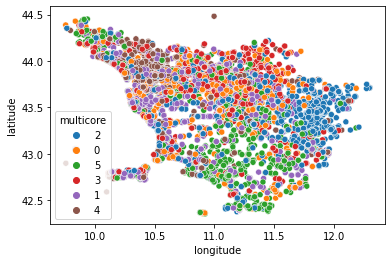

In [18]:
assign(G,multicore,'multicore')
for node in G.nodes:
    df.loc[node,'multicore'] = str(G.nodes[node]['multicore'])

sns.scatterplot(data = df[df.multicore.astype(int)<20], x='longitude',y='latitude',hue='multicore')

In [19]:
readwrite.write_community_json(multicore,'../data/communitiesJ/multicore.json')

### greedy modularity

In [32]:
greedy_modularity = cd.greedy_modularity(G)
readwrite.write_community_json(greedy_modularity,'../data/communities/greedy_modularity.json')


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

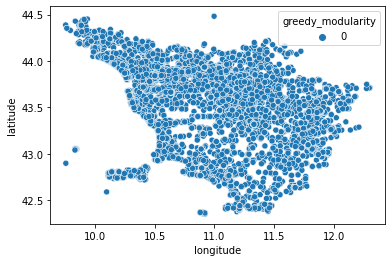

In [33]:
assign(G,greedy_modularity,'greedy_modularity')
for node in G.nodes:
    df.loc[node,'greedy_modularity'] = str(G.nodes[node]['greedy_modularity'])

sns.scatterplot(data = df[df.greedy_modularity.astype(int)<10], x='longitude',y='latitude',hue='greedy_modularity')

In [34]:
greedy_modularity = cd.greedy_modularity(G,weight='dissimilarity')
readwrite.write_community_json(greedy_modularity,'../data/communities/weighted_greedy_modularity.json')


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

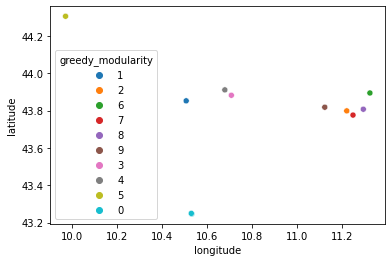

In [35]:
assign(G,greedy_modularity,'greedy_modularity')
for node in G.nodes:
    df.loc[node,'greedy_modularity'] = str(G.nodes[node]['greedy_modularity'])

sns.scatterplot(data = df[df.greedy_modularity.astype(int)<10], x='longitude',y='latitude',hue='greedy_modularity')

### Leiden

In [84]:
leiden= cd.leiden(G)

TypeError: The graph object should be either a networkx or an igraph one.

In [ ]:
#readwrite.write_community_json(leiden,'../data/communities/leiden.json')
assign(G,leiden,'leiden')
for node in G.nodes:
    df.loc[node,'leiden'] = str(G.nodes[node]['leiden'])

sns.scatterplot(data = df[df.leiden.astype(int)<10], x='longitude',y='latitude',hue='leiden')

In [38]:
leiden= cd.leiden(G,weights='dissimilarity')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

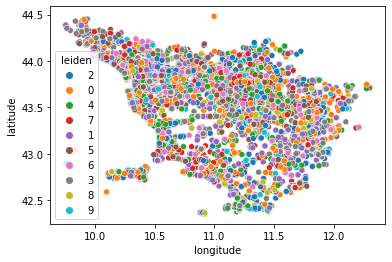

In [39]:
readwrite.write_community_json(leiden,'../data/communities/weighted_leiden.json')
assign(G,leiden,'leiden')
for node in G.nodes:
    df.loc[node,'leiden'] = str(G.nodes[node]['leiden'])

sns.scatterplot(data = df[df.leiden.astype(int)<10], x='longitude',y='latitude',hue='leiden')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

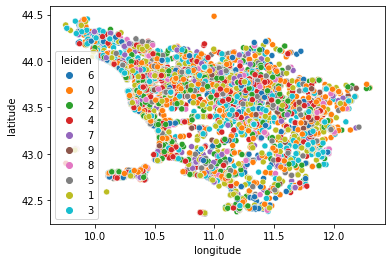

In [40]:
provincemapping = {e:i for i,e in enumerate(df.province.unique())}
for node in G.nodes:
    G.nodes[node]['provint'] = provincemapping[df.loc[node,'province']]
    
leiden_p= cd.leiden(G, initial_membership = [G.nodes[node]['provint'] for node in G.nodes], weights='dissimilarity')
readwrite.write_community_json(leiden_p,'../data/communities/leiden_wp.json')
assign(G,leiden_p,'leiden')
for node in G.nodes:
    df.loc[node,'leiden'] = str(G.nodes[node]['leiden'])
sns.scatterplot(data = df[df.leiden.astype(int)<10], x='longitude',y='latitude',hue='leiden')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

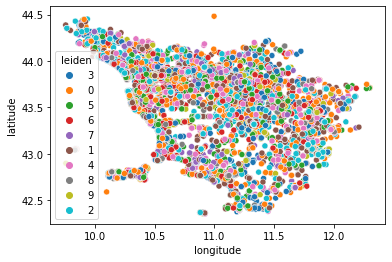

In [41]:
leiden_p= cd.leiden(G, initial_membership = [G.nodes[node]['provint'] for node in G.nodes])
readwrite.write_community_json(leiden_p,'../data/communities/leiden_p.json')
assign(G,leiden_p,'leiden')
for node in G.nodes:
    df.loc[node,'leiden'] = str(G.nodes[node]['leiden'])
sns.scatterplot(data = df[df.leiden.astype(int)<10], x='longitude',y='latitude',hue='leiden')

### Label Propagation

In [42]:
label_propagation = cd.label_propagation(G)
readwrite.write_community_json(label_propagation,'../data/communities/label_propagation.json')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

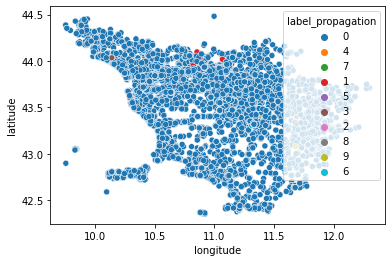

In [43]:

assign(G,label_propagation,'label_propagation')
for node in G.nodes:
    df.loc[node,'label_propagation'] = str(G.nodes[node]['label_propagation'])

sns.scatterplot(data = df[df.label_propagation.astype(int)<10], x='longitude',y='latitude',hue='label_propagation')

### Async Fluid


In [46]:
async_fluid = cd.async_fluid(G,k=10)
readwrite.write_community_json(async_fluid,'../data/communities/async_fluid10.json')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

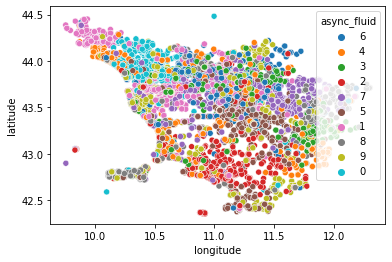

In [47]:
assign(G,async_fluid,'async_fluid')
for node in G.nodes:
    df.loc[node,'async_fluid'] = str(G.nodes[node]['async_fluid'])

sns.scatterplot(data = df[df.async_fluid.astype(int)<10], x='longitude',y='latitude',hue='async_fluid')

### Rb / Rber Pots

In [149]:

provinceMapping= { p:i for i,p in enumerate(df.province.unique())}
for node in G.nodes:
     G.nodes[node]['provint'] = provinceMapping[G.nodes[node]['province']]
                                            

In [48]:
for node in list(G.nodes())[:10]: print(G.nodes[node])

{'province': 'pisa', 'kmeans': '6', 'louvain': 4, 'greedy_modularity': 1, 'leiden': 3, 'provint': 0, 'label_propagation': 0, 'async_fluid': 6}
{'province': 'florence', 'kmeans': '1', 'louvain': 0, 'greedy_modularity': 2, 'leiden': 0, 'provint': 1, 'label_propagation': 0, 'async_fluid': 6}
{'province': 'pistoia', 'kmeans': '9', 'louvain': 4, 'greedy_modularity': 3, 'leiden': 3, 'provint': 4, 'label_propagation': 0, 'async_fluid': 6}
{'province': 'pistoia', 'kmeans': '9', 'louvain': 4, 'greedy_modularity': 4, 'leiden': 0, 'provint': 4, 'label_propagation': 0, 'async_fluid': 6}
{'province': 'massacarrara', 'kmeans': '2', 'louvain': 7, 'greedy_modularity': 5, 'leiden': 0, 'provint': 6, 'label_propagation': 0, 'async_fluid': 1}
{'province': 'prato', 'kmeans': '1', 'louvain': 4, 'greedy_modularity': 6, 'leiden': 0, 'provint': 2, 'label_propagation': 0, 'async_fluid': 4}
{'province': 'florence', 'kmeans': '1', 'louvain': 0, 'greedy_modularity': 7, 'leiden': 0, 'provint': 1, 'label_propagation

In [50]:

rb_pots = cd.rb_pots( G, initial_membership =[G.nodes[node]['provint'] for node in G.nodes()], resolution_parameter=0.7)


readwrite.write_community_json(rb_pots,'../data/communities/rb_pots.json')
print(len(rb_pots.communities),[len(c) for c in rb_pots.communities])

10 [3576, 3415, 2610, 1928, 1298, 1194, 937, 437, 83, 7]


In [71]:
for c in rb_pots.communities: print(len(c))

3335
2929
2712
2508
1741
1008
415
149
65
53
51
21
6
5
5


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

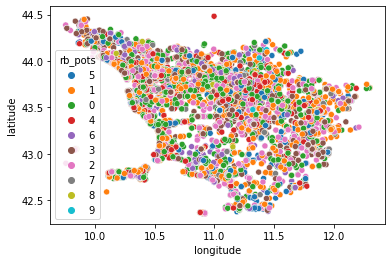

In [51]:
assign(G,rb_pots,'rb_pots')
for node in G.nodes:
    df.loc[node,'rb_pots'] = str(G.nodes[node]['rb_pots'])

sns.scatterplot(data = df[df.rb_pots.astype(int)<20], x='longitude',y='latitude',hue='rb_pots')

In [52]:
for node in G.nodes: G.nodes[node]['size'] = int(df.loc[node,'N_reviews'])

In [54]:
rber_pots = cd.rber_pots(G, initial_membership =[G.nodes[node]['provint'] for node in G.nodes()],node_sizes=[G.nodes[node]['size'] for node in G.nodes()] ,weights='dissimilarity',resolution_parameter=0.8)
readwrite.write_community_json(rber_pots,'../data/communities/rber_pots.json')
print(len(rber_pots.communities))

841


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

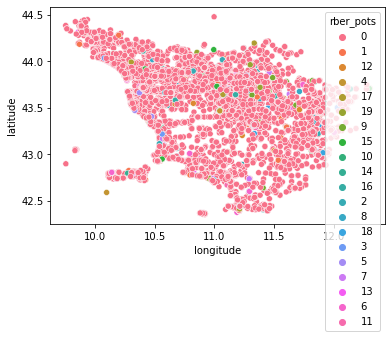

In [55]:
assign(G,rber_pots,'rber_pots')
for node in G.nodes:
    df.loc[node,'rber_pots'] = str(G.nodes[node]['rber_pots'])

sns.scatterplot(data = df[df.rber_pots.astype(int)<20], x='longitude',y='latitude',hue='rber_pots')

## Overlapping Communities

### Angel 

In [56]:
angel = cd.angel(G, min_community_size=10, threshold=0.2)
readwrite.write_community_json(angel,'../data/communities/angel.json')

In [57]:
print(len(angel.communities))
print([len(c) for c in angel.communities ])

6
[8955, 30, 20, 19, 15, 10]


In [30]:
assign(G,angel,'angel',overlap=True)


#sns.scatterplot(data = df[df.greedy_modularity.astype(int)<10], x='longitude',y='latitude',hue='angel')

### Demon

In [58]:
demon = cd.demon(G, min_com_size=10,epsilon=0.1)
print(len(demon.communities))
readwrite.write_community_json(demon,'../data/communities/demon.json')

135


In [59]:
print([len(c) for c in demon.communities ])

[2801, 2574, 2089, 1766, 1634, 1513, 1481, 1469, 1440, 1435, 1323, 1186, 1111, 1098, 1012, 994, 949, 934, 933, 904, 820, 819, 815, 788, 781, 767, 747, 745, 735, 719, 711, 710, 697, 693, 689, 684, 684, 680, 664, 635, 631, 630, 619, 619, 614, 607, 598, 595, 592, 591, 589, 587, 585, 583, 579, 577, 572, 568, 566, 560, 548, 545, 541, 538, 536, 530, 515, 509, 496, 494, 491, 490, 472, 470, 463, 461, 459, 454, 453, 444, 430, 428, 425, 415, 415, 413, 403, 380, 380, 379, 374, 365, 359, 356, 340, 333, 331, 330, 315, 308, 307, 305, 302, 300, 291, 288, 276, 269, 265, 261, 259, 250, 242, 209, 207, 174, 166, 166, 165, 163, 158, 87, 64, 50, 46, 34, 31, 24, 23, 22, 19, 16, 14, 11, 11]


## Evaluation


In [20]:
G = nx.read_weighted_edgelist('../data/connectedJ.weighted.edgelist')
G = nx.relabel_nodes(G, {node:int(node) for node in G.nodes}) 
df = pd.read_csv('../data/connenctedJ.csv',index_col=0)
#for node in G.nodes:
 #   G.nodes[node]['province'] = df.loc[node,'province']
df.head()

,index,position,name,city,menu,link,score,N_reviews,price,Name,...,latitude,longitude,cuisines,meals,specialDiets,positionlink,province,Link,provinceOK,longitud§e
0,0,2018,Osteria al Borgo,Lucca,False,/Restaurant_Review-g187898-d23137800-Reviews-O...,5.0,6,NaN,Osteria al Borgo,...,43.851808,10.506207,"Pizza, Tuscan, Central-Italian",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",j39_https://maps.google.com/maps?saddr=&daddr=...,pisa,/Restaurant_Review-g187898-d23137800-Reviews-O...,0,10.495633
1,12,1309,Il Genio Italiano,Florence,True,/Restaurant_Review-g187895-d2483611-Reviews-Il...,4.0,229,2.5,Il Genio Italiano,...,43.798058,11.219482,"Italian, Pizza, Mediterranean, Tuscan, Central...",NaN,Vegetarian Friendly,vs1_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2483611-Reviews-Il...,1,NaN
2,3,1285,La Locanda di Bivigliano,Bivigliano,False,/Restaurant_Review-g1957776-d13948598-Reviews-...,NaN,28,NaN,La Locanda di Bivigliano,...,43.893859,11.322421,"Italian, Mediterranean, Barbecue, Tuscan, Cent...",NaN,Vegetarian Friendly,rg1_https://maps.google.com/maps?saddr=&daddr=...,prato,/Restaurant_Review-g1957776-d13948598-Reviews-...,0,NaN
3,15,1330,Blend,Sesto Fiorentino,True,/Restaurant_Review-g194916-d12955635-Reviews-B...,4.0,198,2.5,Blend,...,43.830860,11.206403,"Italian, Pizza, Mediterranean, Barbecue","Dinner, Lunch","Vegetarian Friendly, Gluten Free Options",8SH_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g194916-d12955635-Reviews-B...,1,NaN
4,37,1316,La Taverna,Scandicci,False,/Restaurant_Review-g644284-d2660933-Reviews-La...,4.0,236,2.5,La Taverna,...,43.764280,11.180183,"Italian, Pizza, Seafood, Mediterranean",NaN,Vegetarian Friendly,zhJ_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g644284-d2660933-Reviews-La...,1,NaN


In [63]:
nx.is_connected(G)

True

In [21]:
import os 
data = dict()


for f in os.listdir('../data/communitiesJ'):
    if f[-5:] != '.json': continue
   
    name = f[:-5]
    
    communities = readwrite.read_community_json(f'../data/communitiesJ/{f}')
    data[name] = communities
    print(name,' -> ',len(communities.communities),' -> ', [len(c) for c in communities.communities[:20]])

angel  ->  6  ->  [8955, 30, 20, 19, 15, 10]
async_fluid10  ->  10  ->  [1767, 1617, 1606, 1586, 1576, 1558, 1472, 1470, 1446, 1387]
async_fluid7  ->  7  ->  [2430, 2364, 2355, 2210, 2157, 2078, 1891]
demon  ->  135  ->  [2801, 2574, 2089, 1766, 1634, 1513, 1481, 1469, 1440, 1435, 1323, 1186, 1111, 1098, 1012, 994, 949, 934, 933, 904]
greedy_modularity  ->  1  ->  [15485]
kmeans  ->  10  ->  [3599, 2548, 2045, 1712, 1135, 1115, 1069, 1055, 759, 448]
label_propagation  ->  118  ->  [15066, 83, 16, 14, 8, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
leiden  ->  13  ->  [2387, 2348, 1839, 1824, 1566, 1424, 1353, 936, 580, 536, 499, 188, 5]
leiden_p  ->  15  ->  [2562, 2239, 1860, 1836, 1786, 1718, 1355, 916, 599, 526, 39, 17, 13, 12, 7]
leiden_wp  ->  17  ->  [2970, 2323, 1969, 1874, 1705, 1175, 1075, 904, 554, 464, 384, 42, 13, 11, 9, 8, 5]
louvain  ->  17  ->  [2463, 2409, 1894, 1847, 1839, 1336, 1225, 877, 537, 455, 389, 165, 20, 11, 11, 6, 1]
multicore  ->  6  ->  [2982, 2836, 2706, 2

### Collect Fitness

In [22]:
all_evalution_functions = [evaluation.avg_distance, evaluation.avg_embeddedness, evaluation.average_internal_degree, evaluation.avg_transitivity, evaluation.conductance, evaluation.cut_ratio, evaluation.edges_inside, evaluation.expansion,  evaluation.fraction_over_median_degree,  evaluation.hub_dominance,  evaluation.internal_edge_density, evaluation.normalized_cut, evaluation.max_odf, evaluation.avg_odf, evaluation.flake_odf, evaluation.scaled_density, evaluation.significance, evaluation.size , evaluation.surprise , evaluation.triangle_participation_ratio, evaluation.purity]  

In [23]:
evaluation_functions = [ evaluation.avg_embeddedness, evaluation.average_internal_degree, evaluation.avg_transitivity, evaluation.conductance, evaluation.cut_ratio, evaluation.edges_inside, evaluation.expansion,  evaluation.fraction_over_median_degree,  evaluation.hub_dominance,  evaluation.internal_edge_density, evaluation.normalized_cut, evaluation.max_odf, evaluation.avg_odf, evaluation.flake_odf, evaluation.scaled_density, evaluation.significance, evaluation.size , evaluation.surprise , evaluation.triangle_participation_ratio]  

In [75]:
scores = {name:{} for name in data.keys() }
for evaluation_function in evaluation_functions:
    f_name = str(evaluation_function).split(' ')[1].upper()
    print(f_name)
    for name, comm in data.items():
        print(name,end= ' -> ')
        try: 
            ev = evaluation_function(G,comm)
            print(ev)
            scores[name][f_name] = ev.score
            
        except Exception as e: 
            print(e) 
            scores[name][f_name] = np.nan
            
    print('\n\n')

AVG_EMBEDDEDNESS
angel -> FitnessResult(min=0.0, max=0.6083724537518249, score=0.10987472625621382, std=0.22323787529897132)
async_fluid10 -> FitnessResult(min=0.5139984615301689, max=0.6588707161872619, score=0.5650348158399204, std=0.04208716850904325)
async_fluid7 -> FitnessResult(min=0.579600412758429, max=0.6924588219767652, score=0.6337030734280823, std=0.03795270365832636)
demon -> FitnessResult(min=0.21501009718384198, max=0.6806995525482921, score=0.40395508903704236, std=0.05664669128338377)
greedy_modularity -> FitnessResult(min=1.0, max=1.0, score=1.0, std=0.0)
kmeans -> FitnessResult(min=0.49214113516572594, max=0.6813194213764558, score=0.5981328709253376, std=0.06425107057646927)
label_propagation -> FitnessResult(min=0.41666666666666663, max=0.995556353402917, score=0.6408531812498393, std=0.12873988339216835)
leiden -> FitnessResult(min=0.0, max=0.2118871205165494, score=0.1090097158224337, std=0.06407434443079273)
leiden_p -> FitnessResult(min=0.0, max=0.2206322114733

async_fluid7 -> FitnessResult(min=0.0004724020096952786, max=0.0006031217150503531, score=0.0005470821940783966, std=4.459510471794949e-05)
demon -> FitnessResult(min=0.00032318531445931094, max=0.001565767630381821, score=0.001261656410590918, std=0.0001803762697178729)
greedy_modularity -> FitnessResult(min=0, max=0, score=0.0, std=0.0)
kmeans -> FitnessResult(min=0.000513592967749447, max=0.0007324841277211825, score=0.00059915310352854, std=6.969138225880396e-05)
label_propagation -> FitnessResult(min=2.1530379365284418e-05, max=0.0005374047807904779, score=6.585973659441199e-05, std=6.074825005679522e-05)
leiden -> FitnessResult(min=0.0003359173126614987, max=0.0013477150307860321, score=0.0011623850119700165, std=0.00025353249163811883)
leiden_p -> FitnessResult(min=0.0006662158937236497, max=0.0013496150360063348, score=0.0011307614153436127, std=0.0002008358338651078)
leiden_wp -> FitnessResult(min=0.0005419218837005807, max=0.0013502896890079563, score=0.001131189986736437, st

label_propagation -> FitnessResult(min=0.004646531695984069, max=1.0, score=0.9543635463972437, std=0.14121754927185634)
leiden -> FitnessResult(min=0.0, max=0.028877005347593583, score=0.012713136944850581, std=0.006834026244201995)
leiden_p -> FitnessResult(min=0.0, max=0.16666666666666666, score=0.03545318546512478, std=0.04353152556065275)
leiden_wp -> FitnessResult(min=0.0, max=0.1, score=0.024319629403105746, std=0.02985088904987072)
louvain -> division by zero
multicore -> FitnessResult(min=0.020440881763527055, max=0.10051546391752578, score=0.060828356910232396, std=0.022187728906405753)
provinces -> FitnessResult(min=0.014270032930845226, max=0.07341772151898734, score=0.03939816244380004, std=0.017280017905667248)
rber_pots -> division by zero
rb_pots -> FitnessResult(min=0.0, max=0.036585365853658534, score=0.015648188447567626, std=0.011321635062931908)
weighted_greedy_modularity -> division by zero
weighted_leiden -> division by zero



INTERNAL_EDGE_DENSITY
angel -> Fitn

rber_pots -> FitnessResult(min=1.0, max=47.0, score=9.94807715966679, std=8.632464632579504)
rb_pots -> FitnessResult(min=8.857142857142858, max=19.723112128146454, score=15.892150078655044, std=3.073264542823457)
weighted_greedy_modularity -> FitnessResult(min=1.0, max=70.0, score=19.67185481787652, std=13.094932115710362)
weighted_leiden -> FitnessResult(min=1.0, max=20.846153846153847, score=16.05035488805746, std=4.798483660704578)



FLAKE_ODF
angel -> FitnessResult(min=0.16069235064209939, max=1.0, score=0.8601153917736832, std=0.31279149299997056)
async_fluid10 -> FitnessResult(min=0.19920769666100735, max=0.5062240663900415, score=0.39469378473153516, std=0.08804613176523321)
async_fluid7 -> FitnessResult(min=0.19826756496631376, max=0.36911686938127974, score=0.268610312604547, std=0.06303961145229793)
demon -> FitnessResult(min=0.21428571428571427, max=0.9166666666666666, score=0.679561672438887, std=0.09893773742385678)
greedy_modularity -> FitnessResult(min=0.0, max=0.0, sc

C:\Users\carlo\Anaconda3\lib\site-packages\cdlib\evaluation\fitness.py:812: RuntimeWarning: divide by zero encountered in log
  q += binom_c * (pc * np.log(pc / p) + (1 - pc) * np.log((1 - pc) / (1 - p)))
C:\Users\carlo\Anaconda3\lib\site-packages\cdlib\evaluation\fitness.py:812: RuntimeWarning: invalid value encountered in double_scalars
  q += binom_c * (pc * np.log(pc / p) + (1 - pc) * np.log((1 - pc) / (1 - p)))


FitnessResult(min=None, max=None, score=nan, std=None)
async_fluid10 -> FitnessResult(min=None, max=None, score=452740.7224622224, std=None)
async_fluid7 -> FitnessResult(min=None, max=None, score=487707.9753978818, std=None)
demon -> FitnessResult(min=None, max=None, score=3215768.1024604365, std=None)
greedy_modularity -> FitnessResult(min=None, max=None, score=545693.1693756887, std=None)
kmeans -> FitnessResult(min=None, max=None, score=478579.18425844086, std=None)
label_propagation -> FitnessResult(min=None, max=None, score=nan, std=None)
leiden -> FitnessResult(min=None, max=None, score=nan, std=None)
leiden_p -> FitnessResult(min=None, max=None, score=nan, std=None)
leiden_wp -> FitnessResult(min=None, max=None, score=nan, std=None)
louvain -> FitnessResult(min=None, max=None, score=541284.2484950732, std=None)
multicore -> FitnessResult(min=None, max=None, score=319843.639463573, std=None)
provinces -> FitnessResult(min=None, max=None, score=504349.4181749018, std=None)
rber_p

C:\Users\carlo\Anaconda3\lib\site-packages\cdlib\evaluation\fitness.py:769: RuntimeWarning: invalid value encountered in log2
  sp = m * (q * np.log(q / qa) + (1 - q) * np.log2((1 - q) / (1 - qa)))


FitnessResult(min=None, max=None, score=nan, std=None)
greedy_modularity -> FitnessResult(min=None, max=None, score=0, std=None)
kmeans -> FitnessResult(min=None, max=None, score=69930.79009117262, std=None)
label_propagation -> FitnessResult(min=None, max=None, score=4111.2800619244645, std=None)
leiden -> FitnessResult(min=None, max=None, score=-1395.218186063634, std=None)
leiden_p -> FitnessResult(min=None, max=None, score=-1475.600114027997, std=None)
leiden_wp -> FitnessResult(min=None, max=None, score=-1452.8231367166793, std=None)
louvain -> FitnessResult(min=None, max=None, score=102777.29682537694, std=None)
multicore -> FitnessResult(min=None, max=None, score=44525.8602108152, std=None)
provinces -> FitnessResult(min=None, max=None, score=80450.57608915125, std=None)
rber_pots -> FitnessResult(min=None, max=None, score=572.9202455784864, std=None)
rb_pots -> FitnessResult(min=None, max=None, score=-1662.1912050237295, std=None)
weighted_greedy_modularity -> FitnessResult(min

In [40]:
f_df = pd.DataFrame(scores)#, index = [name for name in data.keys()],columns = [str(evaluation_function).split(' ')[1].upper() for evaluation_function in evaluation_functions])

fdf

,angel,async_fluid10,async_fluid7,demon,greedy_modularity,kmeans,label_propagation,leiden,leiden_p,leiden_wp,louvain,multicore,provinces,rber_pots,rb_pots,weighted_greedy_modularity,weighted_leiden
AVG_EMBEDDEDNESS,0.109875,0.565035,0.633703,4.039551e-01,1.000000,0.598133,0.640853,0.109010,0.100372,0.086105,0.633786,0.475916,0.622747,0.003951,0.139816,0.000043,0.081303
AVERAGE_INTERNAL_DEGREE,2.424393,10.896709,12.397301,1.220136e+01,19.670778,11.545680,1.655247,2.051350,1.856243,1.632797,9.221981,8.862762,12.457666,0.039712,2.674002,0.000065,1.515453
AVG_TRANSITIVITY,0.096337,0.194520,0.171494,4.917599e-01,0.108478,0.161472,0.038773,0.073920,0.074011,0.062969,0.166680,0.152849,0.149638,0.000971,0.089622,0.000000,0.062960
CONDUCTANCE,0.886347,0.447623,0.372631,6.077663e-01,0.000000,0.425070,0.406955,0.896750,0.905780,0.917191,0.398693,0.552552,0.388756,0.997417,0.865667,0.999968,0.923903
CUT_RATIO,0.001457,0.000622,0.000547,1.261656e-03,0.000000,0.000599,0.000066,0.001162,0.001131,0.001131,0.000378,0.000843,0.000551,0.000643,0.001148,0.001270,0.001105
EDGES_INSIDE,9585.333333,8531.400000,13742.285714,3.858889e+03,152301.000000,9173.700000,1281.669492,1659.076923,1536.200000,1363.764706,5837.882353,11364.833333,9481.100000,138.399524,3019.800000,0.000065,1126.277778
EXPANSION,20.720728,8.669865,7.262762,1.879550e+01,0.000000,8.378986,0.998540,16.542187,16.249870,16.403145,5.398592,10.870099,7.682342,9.948077,15.892150,19.671855,16.050355
FRACTION_OVER_MEDIAN_DEGREE,0.236016,0.475822,0.477071,4.708639e-01,0.497514,0.483667,0.165868,0.363364,0.324487,0.314756,0.413376,0.469802,0.480592,0.011579,0.353554,0.000000,0.302244
HUB_DOMINANCE,0.057417,0.031918,0.024917,1.487641e-01,0.004521,0.038286,0.954364,0.012713,0.035453,0.024320,NaN,0.020150,0.039398,NaN,0.015648,NaN,NaN
INTERNAL_EDGE_DENSITY,0.004450,0.001749,0.001408,1.314525e-02,0.000318,0.002501,0.202560,0.000422,0.001752,0.000995,0.015976,0.000875,0.002596,0.000618,0.000543,0.000016,0.000644


In [42]:
fdf.to_csv('../data/fitnessMeasuresJ.csv')

### Collect Modularities

In [44]:
all_modularities = [evaluation.erdos_renyi_modularity, evaluation.link_modularity , evaluation.modularity_density , evaluation.newman_girvan_modularity , evaluation.z_modularity]

In [79]:
scores = {name:{} for name in data.keys() }
for modularity in all_modularities:
    m_name = str(modularity).split(' ')[1].upper()
    print(m_name)
    for name, comm in data.items():
        print(name,end= ' -> ')
        try: 
            mod=modularity(G,comm)
            print(mod)
            scores[name][m_name] = mod.score
            
        except Exception as e:
            print(e) 
            scores[name][m_name] = np.nan
            
    print('\n\n')

ERDOS_RENYI_MODULARITY
angel -> FitnessResult(min=None, max=None, score=0.04319577170694734, std=None)
async_fluid10 -> FitnessResult(min=None, max=None, score=0.4597805835387216, std=None)
async_fluid7 -> FitnessResult(min=None, max=None, score=0.48791874309197825, std=None)
demon -> FitnessResult(min=None, max=None, score=3.115386216367572, std=None)
greedy_modularity -> FitnessResult(min=None, max=None, score=0.0, std=None)
kmeans -> FitnessResult(min=None, max=None, score=0.4684340894950798, std=None)
label_propagation -> FitnessResult(min=None, max=None, score=0.04636750618148482, std=None)
leiden -> FitnessResult(min=None, max=None, score=0.033180319883859895, std=None)
leiden_p -> FitnessResult(min=None, max=None, score=0.03516254057454739, std=None)
leiden_wp -> FitnessResult(min=None, max=None, score=0.03326505512387747, std=None)
louvain -> FitnessResult(min=None, max=None, score=0.5391727584801811, std=None)
multicore -> FitnessResult(min=None, max=None, score=0.315207762905

C:\Users\carlo\Anaconda3\lib\site-packages\cdlib\evaluation\fitness.py:722: RuntimeWarning: invalid value encountered in double_scalars
  res = (mmc - dc2m) / np.sqrt(dc2m * (1 - dc2m))


FitnessResult(min=None, max=None, score=nan, std=None)
kmeans -> FitnessResult(min=None, max=None, score=1.4056459384601676, std=None)
label_propagation -> FitnessResult(min=None, max=None, score=0.10097260270887885, std=None)
leiden -> FitnessResult(min=None, max=None, score=0.10231087026037743, std=None)
leiden_p -> FitnessResult(min=None, max=None, score=0.10523579639433721, std=None)
leiden_wp -> FitnessResult(min=None, max=None, score=0.10361113916135085, std=None)
louvain -> FitnessResult(min=None, max=None, score=1.7144500043860915, std=None)
multicore -> FitnessResult(min=None, max=None, score=1.2318895692443195, std=None)
provinces -> FitnessResult(min=None, max=None, score=1.525066762407548, std=None)
rber_pots -> FitnessResult(min=None, max=None, score=0.024626253351561777, std=None)
rb_pots -> FitnessResult(min=None, max=None, score=0.0972013697346664, std=None)
weighted_greedy_modularity -> FitnessResult(min=None, max=None, score=-0.008974234350092066, std=None)
weighted_l

In [46]:
mdf = pd.DataFrame(scores)#, index = [name for name in data.keys()],columns = [str(modularity).split(' ')[1].upper() for modularity in all_modularities])
mdf

,angel,async_fluid10,async_fluid7,demon,greedy_modularity,kmeans,label_propagation,leiden,leiden_p,leiden_wp,louvain,multicore,provinces,rber_pots,rb_pots,weighted_greedy_modularity,weighted_leiden
ERDOS_RENYI_MODULARITY,0.043196,0.459781,0.487919,3.115386,0.000000,0.468434,0.046368,0.033180,0.035163,0.033265,0.539173,0.279065,0.494412,0.161029,0.034996,6.557604e-06,0.032417
LINK_MODULARITY,0.054552,0.081033,0.091369,0.117237,0.144659,0.087134,0.143648,0.020486,0.021887,0.022021,0.094264,0.064767,0.090054,0.110554,0.028683,9.498229e-07,0.019256
MODULARITY_DENSITY,-109.778013,22.268439,35.941770,-890.209844,19.670778,31.666932,77.491360,-188.380877,-215.904405,-251.095928,64.997619,-12.044020,47.753240,-8332.935462,-132.181480,-3.045980e+05,-261.628239
NEWMAN_GIRVAN_MODULARITY,-0.326231,0.557399,0.580483,0.230205,0.000000,0.502586,0.078011,0.046977,0.046157,0.045896,0.634118,0.349859,0.527735,0.011125,0.045218,8.209509e-05,0.039551
Z_MODULARITY,0.009388,1.507329,1.382000,6.529580,NaN,1.405646,0.100973,0.102311,0.105236,0.103611,1.714450,0.747969,1.525067,0.024626,0.097201,-8.974234e-03,0.100247


In [48]:
mdf.to_csv('../data/modularityMeasuresJ.csv')

In [49]:
mdf.transpose()

,ERDOS_RENYI_MODULARITY,LINK_MODULARITY,MODULARITY_DENSITY,NEWMAN_GIRVAN_MODULARITY,Z_MODULARITY
angel,0.043196,5.455227e-02,-109.778013,-0.326231,0.009388
async_fluid10,0.459781,8.103319e-02,22.268439,0.557399,1.507329
async_fluid7,0.487919,9.136916e-02,35.941770,0.580483,1.382000
demon,3.115386,1.172373e-01,-890.209844,0.230205,6.529580
greedy_modularity,0.000000,1.446590e-01,19.670778,0.000000,NaN
kmeans,0.468434,8.713390e-02,31.666932,0.502586,1.405646
label_propagation,0.046368,1.436484e-01,77.491360,0.078011,0.100973
leiden,0.033180,2.048578e-02,-188.380877,0.046977,0.102311
leiden_p,0.035163,2.188677e-02,-215.904405,0.046157,0.105236
leiden_wp,0.033265,2.202069e-02,-251.095928,0.045896,0.103611


In [83]:
m_df.columns

Index(['angel', 'async_fluid10', 'async_fluid7', 'demon', 'greedy_modularity',
       'kmeans', 'label_propagation', 'leiden', 'leiden_p', 'leiden_wp',
       'louvain', 'multicore', 'provinces', 'rber_pots', 'rb_pots',
       'weighted_greedy_modularity', 'weighted_leiden'],
      dtype='object')

In [84]:
 for name, comm in data.items():
        if comm.node_coverage==1:
            print(name,' -> ', evaluation.adjusted_mutual_information(comm, data['provinces']).score)

async_fluid10  ->  0.27597804969986595
async_fluid7  ->  0.3160422523014557
greedy_modularity  ->  -7.685799456268897e-16
kmeans  ->  0.70976079374463
label_propagation  ->  0.014743386119135444
leiden  ->  0.018403833463819994
leiden_p  ->  0.020295636961774784
leiden_wp  ->  0.020857991126838123
louvain  ->  0.5240196777074465
multicore  ->  0.2257026498397007
provinces  ->  1.0
rber_pots  ->  0.005266759444274312
rb_pots  ->  0.020851158732681858
weighted_greedy_modularity  ->  2.0894126904839363e-05
weighted_leiden  ->  0.0179950202591776


## MORE

In [50]:
import os 
data = dict()


for f in os.listdir('../data/communitiesJ'):
    if f[-5:] != '.json': continue
   
    name = f[:-5]
    
    communities = readwrite.read_community_json(f'../data/communitiesJ/{f}')
    data[name] = communities
    print(name,' -> ',len(communities.communities),' -> ', [len(c) for c in communities.communities[:20]])

angel  ->  6  ->  [8955, 30, 20, 19, 15, 10]
async_fluid10  ->  10  ->  [1767, 1617, 1606, 1586, 1576, 1558, 1472, 1470, 1446, 1387]
async_fluid7  ->  7  ->  [2430, 2364, 2355, 2210, 2157, 2078, 1891]
demon  ->  135  ->  [2801, 2574, 2089, 1766, 1634, 1513, 1481, 1469, 1440, 1435, 1323, 1186, 1111, 1098, 1012, 994, 949, 934, 933, 904]
greedy_modularity  ->  1  ->  [15485]
kmeans  ->  10  ->  [3599, 2548, 2045, 1712, 1135, 1115, 1069, 1055, 759, 448]
label_propagation  ->  118  ->  [15066, 83, 16, 14, 8, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
leiden  ->  13  ->  [2387, 2348, 1839, 1824, 1566, 1424, 1353, 936, 580, 536, 499, 188, 5]
leiden_p  ->  15  ->  [2562, 2239, 1860, 1836, 1786, 1718, 1355, 916, 599, 526, 39, 17, 13, 12, 7]
leiden_wp  ->  17  ->  [2970, 2323, 1969, 1874, 1705, 1175, 1075, 904, 554, 464, 384, 42, 13, 11, 9, 8, 5]
louvain  ->  17  ->  [2463, 2409, 1894, 1847, 1839, 1336, 1225, 877, 537, 455, 389, 165, 20, 11, 11, 6, 1]
multicore  ->  6  ->  [2982, 2836, 2706, 2

In [51]:
G = nx.read_weighted_edgelist('../data/connectedJ.weighted.edgelist')
G = nx.relabel_nodes(G, {node:int(node) for node in G.nodes}) 
mdf = pd.read_csv('../data/modularityMeasuresJ.csv',index_col=0)
fdf = pd.read_csv('../data/fitnessMeasuresJ.csv',index_col=0)

In [52]:
mdf.transpose()

,ERDOS_RENYI_MODULARITY,LINK_MODULARITY,MODULARITY_DENSITY,NEWMAN_GIRVAN_MODULARITY,Z_MODULARITY
angel,0.043196,5.455227e-02,-109.778013,-0.326231,0.009388
async_fluid10,0.459781,8.103319e-02,22.268439,0.557399,1.507329
async_fluid7,0.487919,9.136916e-02,35.941770,0.580483,1.382000
demon,3.115386,1.172373e-01,-890.209844,0.230205,6.529580
greedy_modularity,0.000000,1.446590e-01,19.670778,0.000000,NaN
kmeans,0.468434,8.713390e-02,31.666932,0.502586,1.405646
label_propagation,0.046368,1.436484e-01,77.491360,0.078011,0.100973
leiden,0.033180,2.048578e-02,-188.380877,0.046977,0.102311
leiden_p,0.035163,2.188677e-02,-215.904405,0.046157,0.105236
leiden_wp,0.033265,2.202069e-02,-251.095928,0.045896,0.103611


In [89]:
fdf.transpose()

,AVG_EMBEDDEDNESS,AVERAGE_INTERNAL_DEGREE,AVG_TRANSITIVITY,CONDUCTANCE,CUT_RATIO,EDGES_INSIDE,EXPANSION,FRACTION_OVER_MEDIAN_DEGREE,HUB_DOMINANCE,INTERNAL_EDGE_DENSITY,NORMALIZED_CUT,MAX_ODF,AVG_ODF,FLAKE_ODF,SCALED_DENSITY,SIGNIFICANCE,SIZE,SURPRISE,TRIANGLE_PARTICIPATION_RATIO
angel,0.109875,2.424393,0.096337,0.886347,0.001457,9585.333333,20.720728,0.236016,0.057417,0.004450,0.932948,44.666667,20.720728,0.860115,14.010020,NaN,1508.166667,-2189.834151,0.201675
async_fluid10,0.565035,10.896709,0.194520,0.447623,0.000622,8531.400000,8.669865,0.475822,0.031918,0.001749,0.492158,37.300000,8.669865,0.394694,5.506801,4.527407e+05,1548.500000,77518.482844,0.728575
async_fluid7,0.633703,12.397301,0.171494,0.372631,0.000547,13742.285714,7.262762,0.477071,0.024917,0.001408,0.427313,35.142857,7.262762,0.268610,4.432993,4.877080e+05,2212.142857,74149.364550,0.745794
demon,0.403955,12.201357,0.491760,0.607766,0.001262,3858.888889,18.795504,0.470864,0.148764,0.013145,0.642767,49.881481,18.795504,0.679562,41.389523,3.215768e+06,577.437037,NaN,1.000000
greedy_modularity,1.000000,19.670778,0.108478,0.000000,0.000000,152301.000000,0.000000,0.497514,0.004521,0.000318,0.000000,0.000000,0.000000,0.000000,1.000000,5.456932e+05,15485.000000,0.000000,0.801227
kmeans,0.598133,11.545680,0.161472,0.425070,0.000599,9173.700000,8.378986,0.483667,0.038286,0.002501,0.466005,44.900000,8.378986,0.316322,7.873418,4.785792e+05,1548.500000,69930.790091,0.754893
label_propagation,0.640853,1.655247,0.038773,0.406955,0.000066,1281.669492,0.998540,0.165868,0.954364,0.202560,0.408598,1.898305,0.998540,0.051373,637.787595,NaN,131.228814,4111.280062,0.063074
leiden,0.109010,2.051350,0.073920,0.896750,0.001162,1659.076923,16.542187,0.363364,0.012713,0.000422,0.958244,53.769231,16.542187,0.968123,1.329062,NaN,1191.153846,-1395.218186,0.199349
leiden_p,0.100372,1.856243,0.074011,0.905780,0.001131,1536.200000,16.249870,0.324487,0.035453,0.001752,0.958259,51.866667,16.249870,0.967938,5.516491,NaN,1032.333333,-1475.600114,0.191787
leiden_wp,0.086105,1.632797,0.062969,0.917191,0.001131,1363.764706,16.403145,0.314756,0.024320,0.000995,0.963536,49.941176,16.403145,0.973747,3.131831,NaN,910.882353,-1452.823137,0.165619


In [53]:
for name, comm in data.items():
    print(name,len(comm.communities),[len(c) for c in comm.communities[:10]])

provinces 10 [3645, 1949, 1796, 1647, 1571, 1460, 1124, 967, 791, 535]
kmeans 10 [3599, 2548, 2045, 1712, 1135, 1115, 1069, 1055, 759, 448]
louvain 17 [2463, 2409, 1894, 1847, 1839, 1336, 1225, 877, 537, 455]
greedy_modularity 1 [15485]
weighted_greedy_modularity 15484 [2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
leiden 13 [2387, 2348, 1839, 1824, 1566, 1424, 1353, 936, 580, 536]
weighted_leiden 18 [2268, 2119, 1821, 1757, 1677, 1420, 1099, 965, 644, 606]
leiden_wp 17 [2970, 2323, 1969, 1874, 1705, 1175, 1075, 904, 554, 464]
leiden_p 15 [2562, 2239, 1860, 1836, 1786, 1718, 1355, 916, 599, 526]
label_propagation 118 [15066, 83, 16, 14, 8, 6, 5, 5, 5, 5]
async_fluid10 10 [1767, 1617, 1606, 1586, 1576, 1558, 1472, 1470, 1446, 1387]
async_fluid7 7 [2430, 2364, 2355, 2210, 2157, 2078, 1891]
rb_pots 10 [3576, 3415, 2610, 1928, 1298, 1194, 937, 437, 83, 7]
rber_pots 841 [12024, 84, 76, 53, 51, 50, 46, 45, 44, 42]
angel 6 [8955, 30, 20, 19, 15, 10]
demon 135 [2801, 2574, 2089, 1766, 1634, 1513, 1481, 1469, 

In [53]:
bestPartitions = ['provinces', 'kmeans', 'louvain','multicore','async_fluid7','demon']

In [54]:
fdf[bestPartitions]

,provinces,kmeans,louvain,multicore,async_fluid7,demon
AVG_EMBEDDEDNESS,0.622747,0.598133,0.633786,0.475916,0.633703,4.039551e-01
AVERAGE_INTERNAL_DEGREE,12.457666,11.545680,9.221981,8.862762,12.397301,1.220136e+01
AVG_TRANSITIVITY,0.149638,0.161472,0.166680,0.152849,0.171494,4.917599e-01
CONDUCTANCE,0.388756,0.425070,0.398693,0.552552,0.372631,6.077663e-01
CUT_RATIO,0.000551,0.000599,0.000378,0.000843,0.000547,1.261656e-03
EDGES_INSIDE,9481.100000,9173.700000,5837.882353,11364.833333,13742.285714,3.858889e+03
EXPANSION,7.682342,8.378986,5.398592,10.870099,7.262762,1.879550e+01
FRACTION_OVER_MEDIAN_DEGREE,0.480592,0.483667,0.413376,0.469802,0.477071,4.708639e-01
HUB_DOMINANCE,0.039398,0.038286,NaN,0.020150,0.024917,1.487641e-01
INTERNAL_EDGE_DENSITY,0.002596,0.002501,0.015976,0.000875,0.001408,1.314525e-02


In [55]:
mdf[bestPartitions].transpose()

,ERDOS_RENYI_MODULARITY,LINK_MODULARITY,MODULARITY_DENSITY,NEWMAN_GIRVAN_MODULARITY,Z_MODULARITY
provinces,0.494412,0.090054,47.753240,0.527735,1.525067
kmeans,0.468434,0.087134,31.666932,0.502586,1.405646
louvain,0.539173,0.094264,64.997619,0.634118,1.714450
multicore,0.279065,0.064767,-12.044020,0.349859,0.747969
async_fluid7,0.487919,0.091369,35.941770,0.580483,1.382000
demon,3.115386,0.117237,-890.209844,0.230205,6.529580


(5,) (5,)
[ 0.49441183  0.09005366 47.75324026  0.52773525  1.52506676]
(5,) (5,)
[ 0.46843409  0.0871339  31.66693209  0.50258587  1.40564594]
(5,) (5,)
[ 0.53917276  0.09426422 64.99761871  0.63411783  1.71445   ]
(5,) (5,)
[  0.2790647    0.06476747 -12.04401959   0.34985878   0.74796913]
(5,) (5,)
[ 0.48791874  0.09136916 35.94176991  0.58048289  1.38199963]
(5,) (5,)
[ 3.11538622e+00  1.17237314e-01 -8.90209844e+02  2.30204740e-01
  6.52957964e+00]


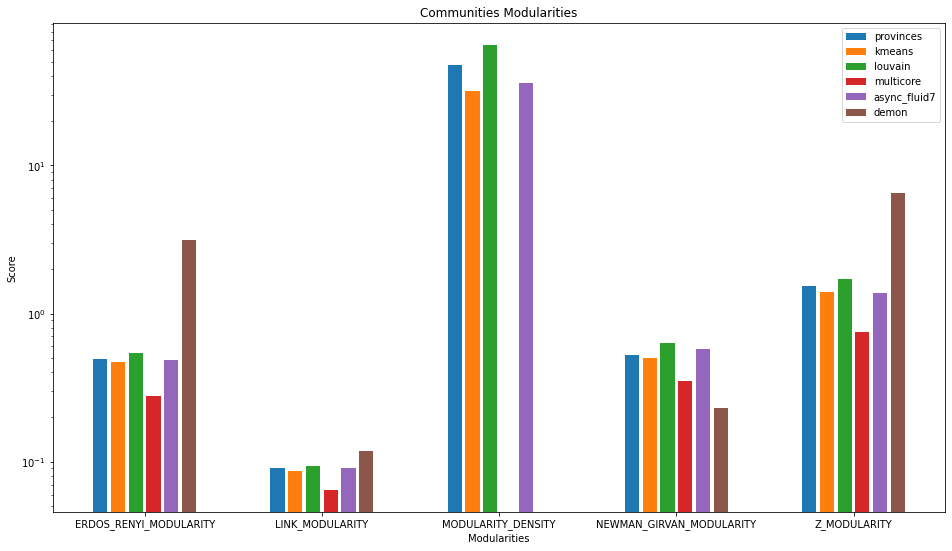

In [81]:
bins = [i for i in range(len(mdf[bestPartitions].index))]
width = 0.1
barwidth = 0.08

plt.figure(figsize=(16,9))

for i, partition in enumerate(bestPartitions):
    pos = np.array(bins) - width*2.5+width*i
    heights = np.array(mdf[partition])
    #heights = (heights - min(heights)) / (max(heights) - min(heights))
    #§heights = (heights ) / (max(heights))
    print(np.shape(pos),np.shape(heights))
    print(heights)
    plt.bar(pos,heights,barwidth,label=partition)
    

plt.title("Communities Modularities")
plt.ylabel("Score")
plt.xlabel("Modularities")
plt.xticks(bins,labels=[modularity for  modularity in mdf[bestPartitions].index])

plt.yscale('log')

plt.legend(bestPartitions)
plt.show()


In [57]:
 for name, comm in data.items():
        if comm.node_coverage==1 and name in bestPartitions:
            
            print(name,' -> ', evaluation.adjusted_mutual_information(comm, data['provinces']).score)

async_fluid7  ->  0.3160422523014557
kmeans  ->  0.70976079374463
louvain  ->  0.5240196777074465
multicore  ->  0.1370070691712249
provinces  ->  1.0


In [58]:
 for name, comm in data.items():
        if name in bestPartitions:
            
            print(name,' -> ', evaluation.nf1(comm, data['provinces']).score)

async_fluid7  ->  0.16071428571428573
demon  ->  0.0007956104252400548
kmeans  ->  0.42624000000000006
louvain  ->  0.1886262975778547
multicore  ->  0.17013888888888892
provinces  ->  1.0


In [59]:
nf1matrix = [[] for _ in bestPartitions]
for i,c1 in enumerate(bestPartitions):
    for j, c2 in enumerate(bestPartitions):
        nf1matrix[i].append(evaluation.nf1(data[c1], data[c2]).score)

In [60]:
df = pd.DataFrame( nf1matrix,index = bestPartitions, columns = bestPartitions)
df

,provinces,kmeans,louvain,multicore,async_fluid7,demon
provinces,1.000000,0.315070,0.250353,0.178800,0.217870,0.017820
kmeans,0.426240,1.000000,0.214212,0.152400,0.207257,0.016860
louvain,0.188626,0.175453,1.000000,0.065398,0.119170,0.018980
multicore,0.170139,0.095556,0.146471,1.000000,0.312857,0.004543
async_fluid7,0.160714,0.170408,0.175030,0.302449,1.000000,0.009034
demon,0.000796,0.000858,0.000682,0.000334,0.000559,0.079458


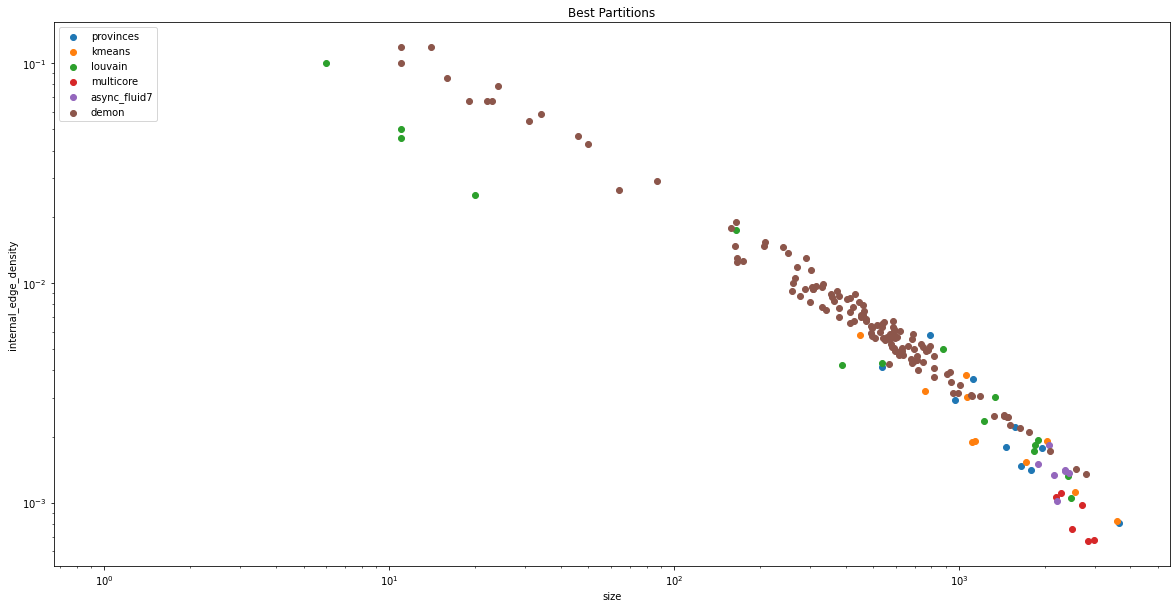

In [82]:
bestPartitions = ['provinces', 'kmeans', 'louvain','multicore','async_fluid7','demon']
bestp = ['provinces', 'kmeans']

plt.figure(figsize=(20,10))
for partition in bestPartitions:
    size = evaluation.size(G,data[partition],summary=False)
    internal_edge_density= evaluation.internal_edge_density(G,data[partition],summary=False)
    plt.scatter(size,internal_edge_density)
  
plt.title('Best Partitions')
plt.xlabel('size')
plt.ylabel('internal_edge_density')
plt.xscale('log')
plt.yscale('log')
plt.legend([p for p in bestPartitions],loc=2)
plt.show()

In [45]:
scores = {name:{} for name in data.keys() }
for modularity in all_modularities:
    m_name = str(modularity).split(' ')[1].upper()
    print(m_name)
    for name, comm in data.items():
        print(name,end= ' -> ')
        try: 
            mod=modularity(G,comm)
            print(mod)
            scores[name][m_name] = mod.score
            
        except Exception as e:
            print(e) 
            scores[name][m_name] = np.nan
            
    print('\n\n')

ERDOS_RENYI_MODULARITY
multicore -> FitnessResult(min=None, max=None, score=0.279064695938287, std=None)



LINK_MODULARITY
multicore -> FitnessResult(min=None, max=None, score=0.06476747311476534, std=None)



MODULARITY_DENSITY
multicore -> FitnessResult(min=None, max=None, score=-12.044019588667627, std=None)



NEWMAN_GIRVAN_MODULARITY
multicore -> FitnessResult(min=None, max=None, score=0.3498587777862324, std=None)



Z_MODULARITY
multicore -> FitnessResult(min=None, max=None, score=0.7479691294095845, std=None)





In [19]:
evaluation.avg_transitivity(G,data['louvain'],summary=False)

[0.12497936572919267,
 0.14804413715273382,
 0.15881921693632464,
 0.19723119987542714,
 0.17156050182687127,
 0.20734255270578,
 0.22385687741030116,
 0.18829226246544156,
 0.1749706407739214,
 0.3415764597106315,
 0.20592209164842623,
 0.41318011770827207,
 0.0,
 0.0,
 0.0,
 0.27777777777777773,
 0.0]

## DEMON analysis

In [7]:
bestPartitions = ['provinces', 'kmeans', 'louvain','async_fluid7','demon']

In [67]:
from cdlib import ensemble

epsilon = ensemble.Parameter(name="epsilon", start=0.1, end=0.95, step=0.05)
min_com_size = ensemble.Parameter(name="min_com_size", start=7, end=30, step=3)
communities, scoring = ensemble.random_search(graph=G, method=cd.demon,
                                                   parameters=[epsilon, min_com_size],
                                                     quality_score=evaluation.modularity_density,

                                              instances=20, aggregate=max)

In [92]:
print(len(communities.communities), [len(c) for c in communities.communities[:30]])
scoring


88 [2762, 2686, 2192, 1937, 1795, 1626, 1508, 1451, 1311, 1176, 1094, 1038, 1034, 1016, 943, 920, 888, 874, 861, 846, 805, 785, 783, 753, 722, 718, 692, 684, 676, 670]


FitnessResult(min=None, max=None, score=-445.968981485347, std=None)

In [73]:

readwrite.write_community_json(communities,'../data/communities/best_demon.json')

In [85]:
scores = dict()
for evaluation_function in evaluation_functions:
    f_name = str(evaluation_function).split(' ')[1].upper()
    print(f_name,end= ' -> ')
    try: 
        ev = evaluation_function(G,communities)
        print(ev)
        scores[f_name] = ev.score

    except Exception as e: 
        print(e) 
        scores[f_name] = np.nan

AVG_EMBEDDEDNESS -> FitnessResult(min=0.20256094861324986, max=0.5293011842248415, score=0.42573216234039146, std=0.053378570916549094)
AVERAGE_INTERNAL_DEGREE -> FitnessResult(min=4.9523809523809526, max=17.382151029748282, score=13.531294903840006, std=2.124119347791685)
AVG_TRANSITIVITY -> FitnessResult(min=0.3263208649727251, max=0.8034834519295105, score=0.4744669779685644, std=0.08643821173053093)
CONDUCTANCE -> FitnessResult(min=0.47265839129746257, max=0.8095238095238095, score=0.5801372803667318, std=0.05688571332691644)
CUT_RATIO -> FitnessResult(min=0.0009768355644903368, max=0.0014476947371216916, score=0.0012526505189665838, std=9.074001478958819e-05)
EDGES_INSIDE -> FitnessResult(min=52, max=21645, score=4677.943181818182, std=4179.5247483142975)
EXPANSION -> FitnessResult(min=14.445644080416978, max=21.71252566735113, score=18.599124238900767, std=1.647192451559863)
FRACTION_OVER_MEDIAN_DEGREE -> FitnessResult(min=0.36363636363636365, max=0.5, score=0.4752432473068915, s

/home/ec2-user/.local/lib/python3.7/site-packages/cdlib/evaluation/fitness.py:769: RuntimeWarning: invalid value encountered in log2
  sp = m * (q * np.log(q / qa) + (1 - q) * np.log2((1 - q) / (1 - qa)))


FitnessResult(min=None, max=None, score=nan, std=None)
TRIANGLE_PARTICIPATION_RATIO -> FitnessResult(min=1.0, max=1.0, score=1.0, std=0.0)


In [86]:
fdf['best_demon'] = scores.values()

fdf[bestPartitions]

,provinces,kmeans,louvain,async_fluid7,demon,best_demon
AVG_EMBEDDEDNESS,0.622747,0.598133,0.633786,0.633703,4.039551e-01,4.257322e-01
AVERAGE_INTERNAL_DEGREE,12.457666,11.545680,9.221981,12.397301,1.220136e+01,1.353129e+01
AVG_TRANSITIVITY,0.149638,0.161472,0.166680,0.171494,4.917599e-01,4.744670e-01
CONDUCTANCE,0.388756,0.425070,0.398693,0.372631,6.077663e-01,5.801373e-01
CUT_RATIO,0.000551,0.000599,0.000378,0.000547,1.261656e-03,1.252651e-03
EDGES_INSIDE,9481.100000,9173.700000,5837.882353,13742.285714,3.858889e+03,4.677943e+03
EXPANSION,7.682342,8.378986,5.398592,7.262762,1.879550e+01,1.859912e+01
FRACTION_OVER_MEDIAN_DEGREE,0.480592,0.483667,0.413376,0.477071,4.708639e-01,4.752432e-01
HUB_DOMINANCE,0.039398,0.038286,NaN,0.024917,1.487641e-01,1.149746e-01
INTERNAL_EDGE_DENSITY,0.002596,0.002501,0.015976,0.001408,1.314525e-02,9.697659e-03


In [87]:
scores = dict()
for evaluation_function in all_modularities:
    f_name = str(evaluation_function).split(' ')[1].upper()
    print(f_name,end= ' -> ')
    try: 
        ev = evaluation_function(G,communities)
        print(ev)
        scores[f_name] = ev.score

    except Exception as e: 
        print(e) 
        scores[f_name] = np.nan

ERDOS_RENYI_MODULARITY -> FitnessResult(min=None, max=None, score=2.450397680535787, std=None)
LINK_MODULARITY -> FitnessResult(min=None, max=None, score=0.09787545054568741, std=None)
MODULARITY_DENSITY -> FitnessResult(min=None, max=None, score=-445.968981485347, std=None)
NEWMAN_GIRVAN_MODULARITY -> FitnessResult(min=None, max=None, score=0.20685187983342135, std=None)
Z_MODULARITY -> FitnessResult(min=None, max=None, score=4.317548809209999, std=None)


In [88]:
mdf['best_demon'] = scores.values()
mdf[bestPartitions]

,provinces,kmeans,louvain,async_fluid7,demon,best_demon
ERDOS_RENYI_MODULARITY,0.494412,0.468434,0.539173,0.487919,3.115386,2.450398
LINK_MODULARITY,0.090054,0.087134,0.094264,0.091369,0.117237,0.097875
MODULARITY_DENSITY,47.753240,31.666932,64.997619,35.941770,-890.209844,-445.968981
NEWMAN_GIRVAN_MODULARITY,0.527735,0.502586,0.634118,0.580483,0.230205,0.206852
Z_MODULARITY,1.525067,1.405646,1.714450,1.382000,6.529580,4.317549


In [8]:
def plot_kcentral(G,dictionary,k=10):
    sorted_dictionary =  sorted(dictionary.items(), key=lambda x: x[1],reverse = True)
    nodes, values = zip(*sorted_dictionary)
    nodes = nodes[:k]
    values = values[:k]
    names = [G.nodes[node]['name'] for node in nodes]
    
    plt.figure(figsize=(20,5))
    plt.bar(names, values, color=sns.color_palette('ocean',k))
    plt.xticks(rotation=25)

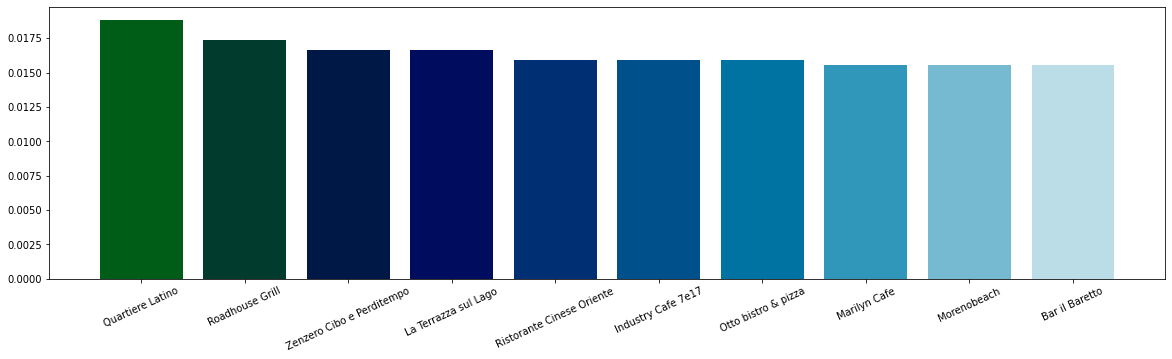

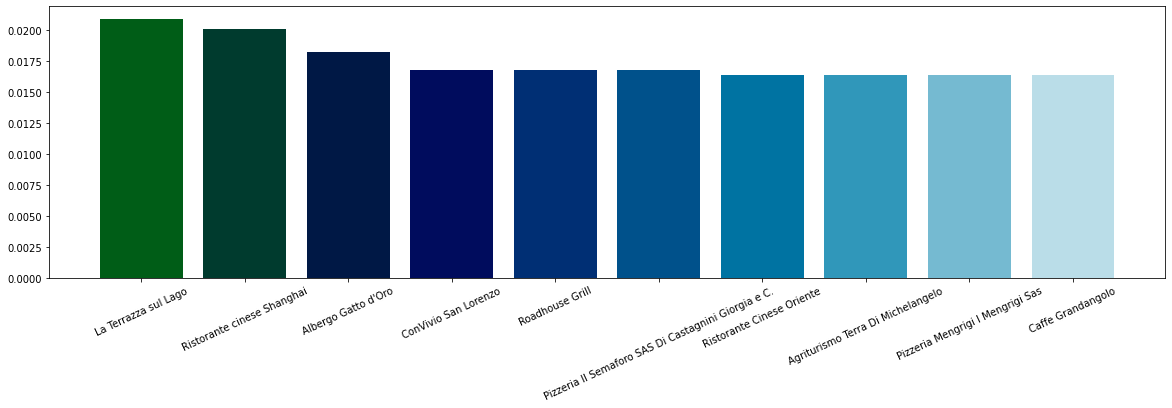

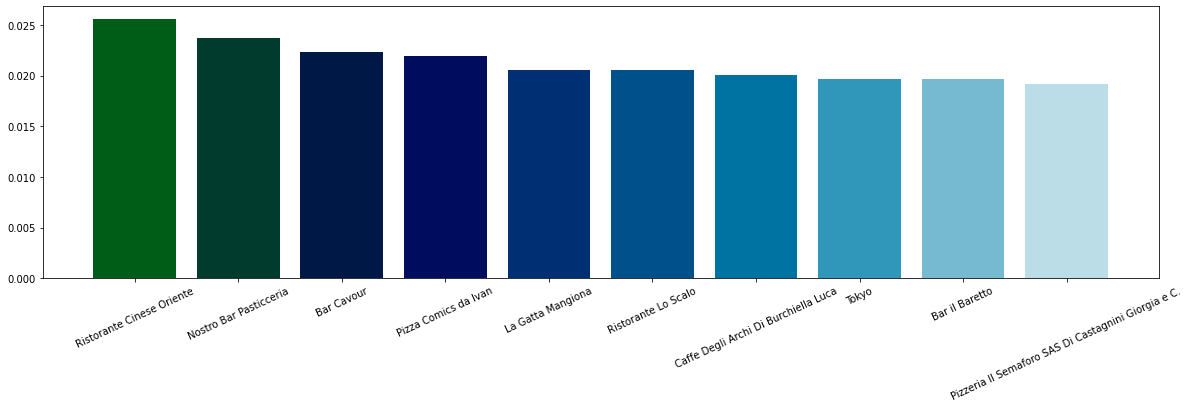

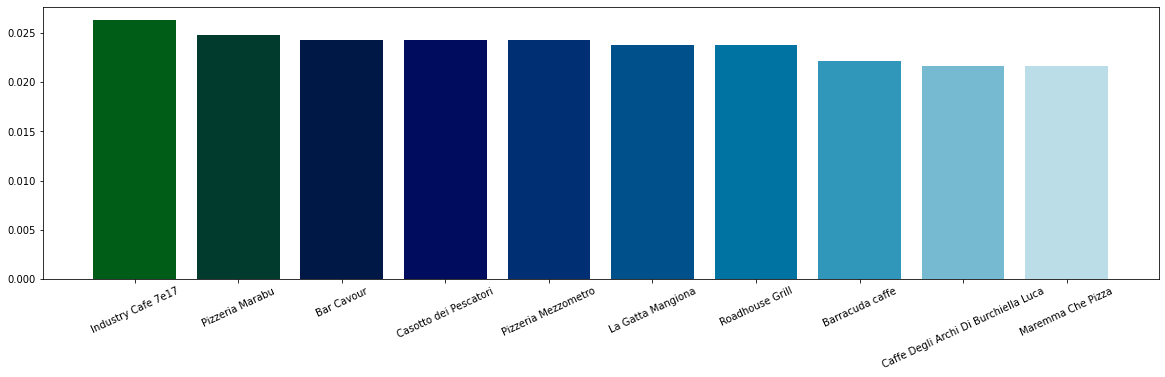

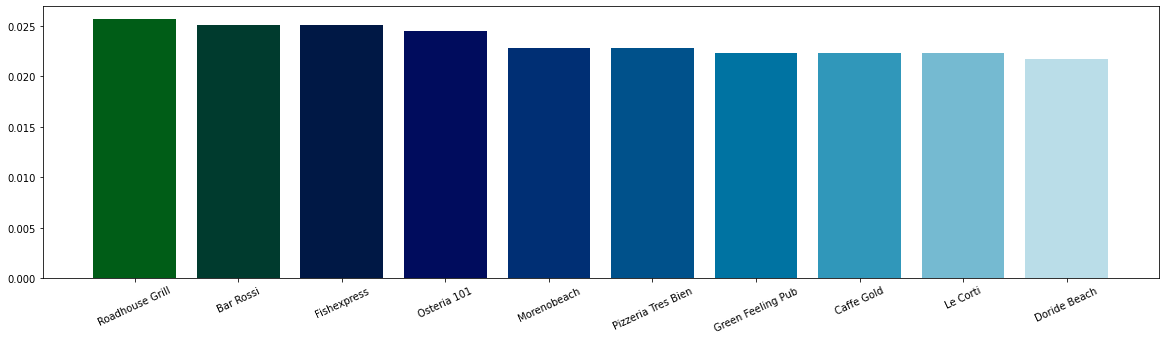

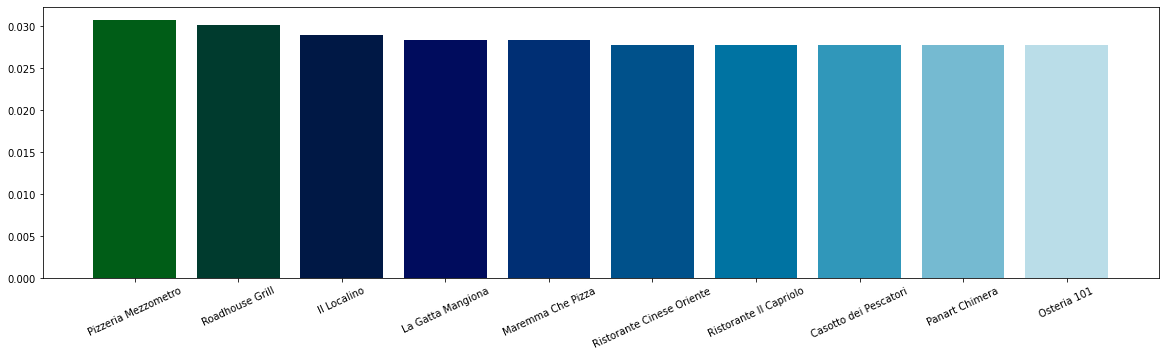

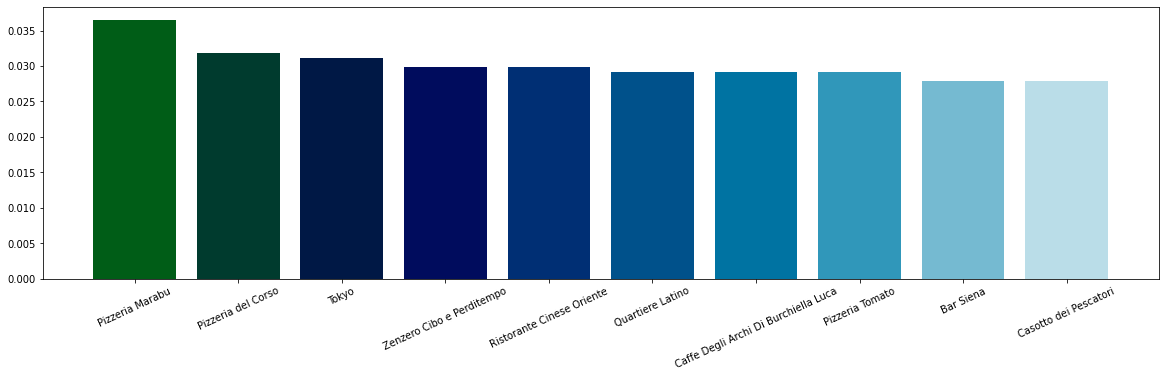

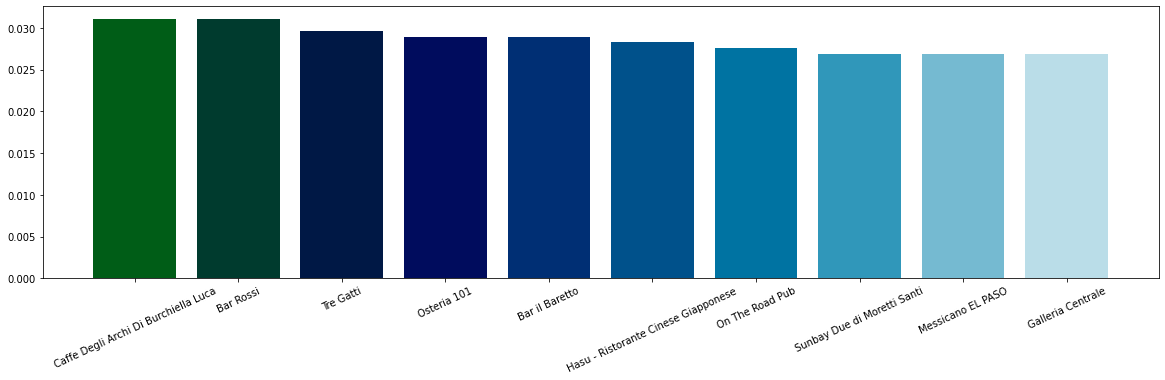

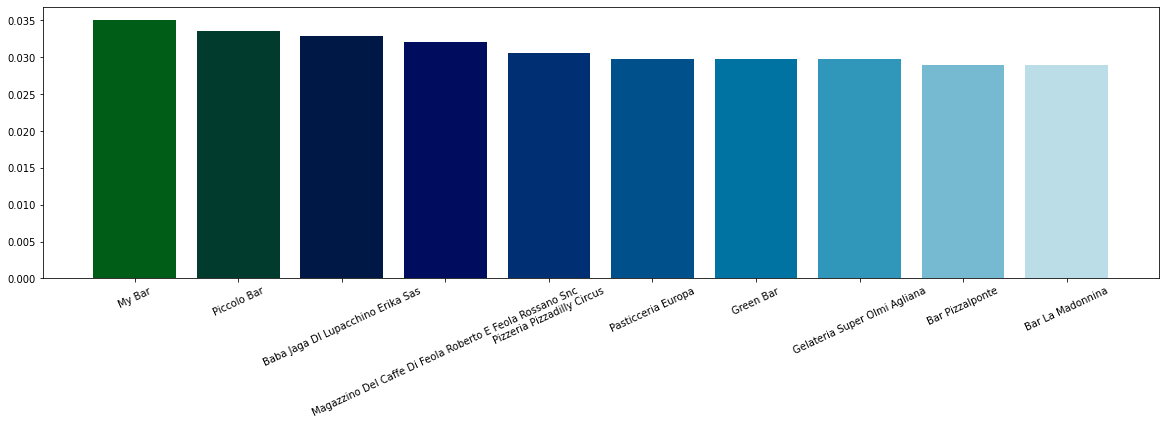

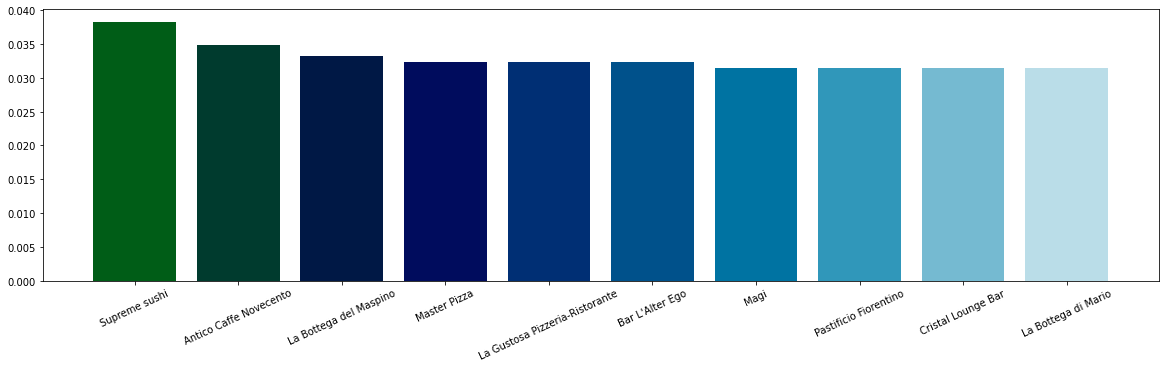

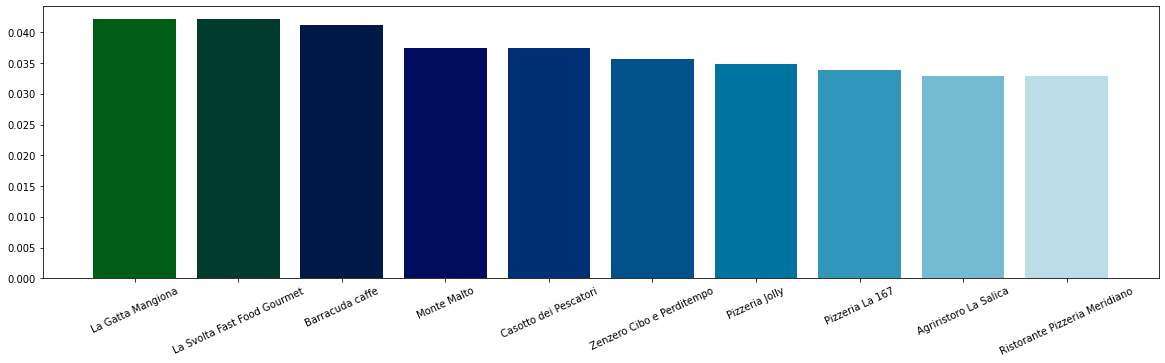

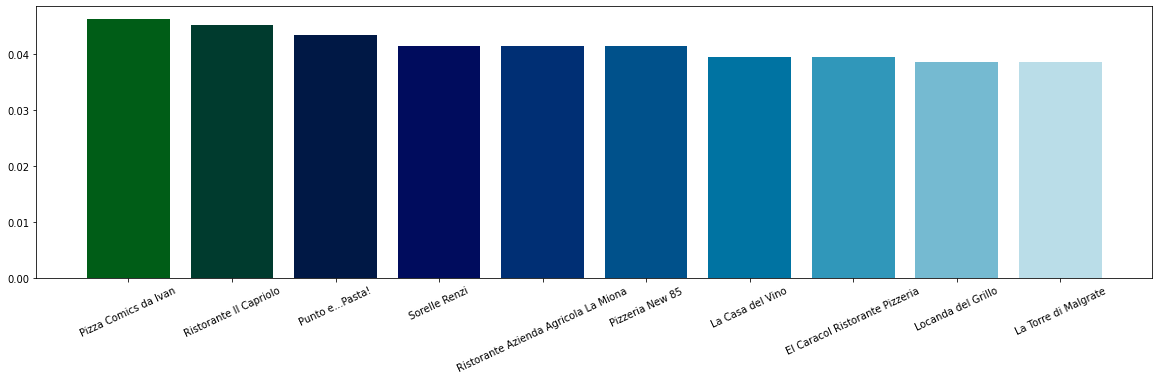

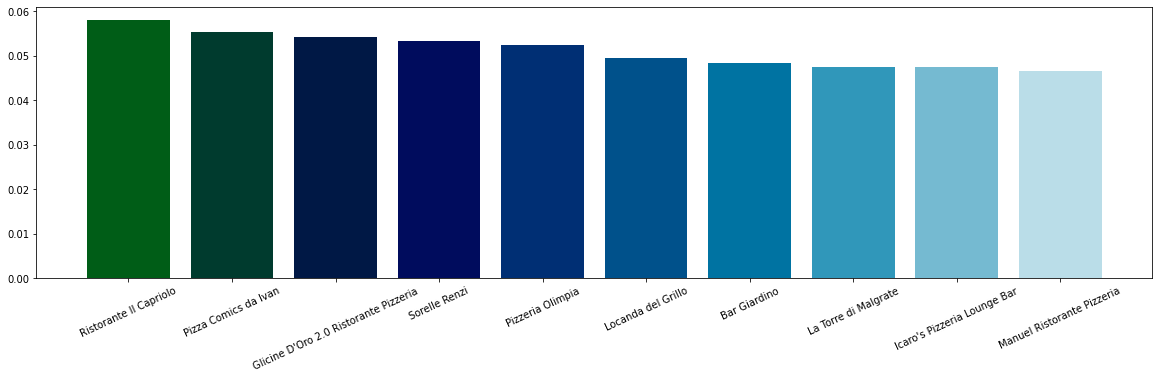

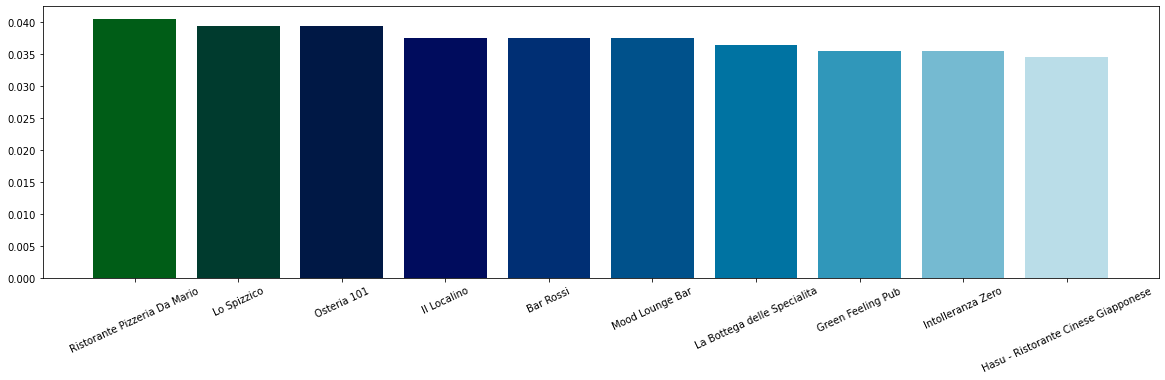

In [13]:
for c in data['best_demon'].communities:
    if len(c) <1000: continue 
    C = G.subgraph(c).copy()
    degree_centrality = nx.degree_centrality(C)
    plot_kcentral(C,degree_centrality,10)

### Louvain  Analysis


In [9]:
print(len(data['louvain'].communities),[len(c) for c in data['louvain'].communities])


17 [2463, 2409, 1894, 1847, 1839, 1336, 1225, 877, 537, 455, 389, 165, 20, 11, 11, 6, 1]


In [10]:
for node in G.nodes:
    G.nodes[node]['name'] = df.loc[node,'name']

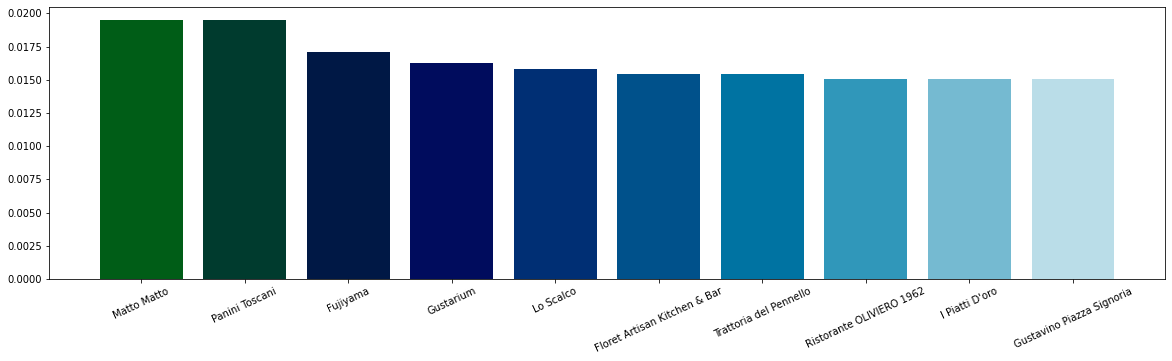

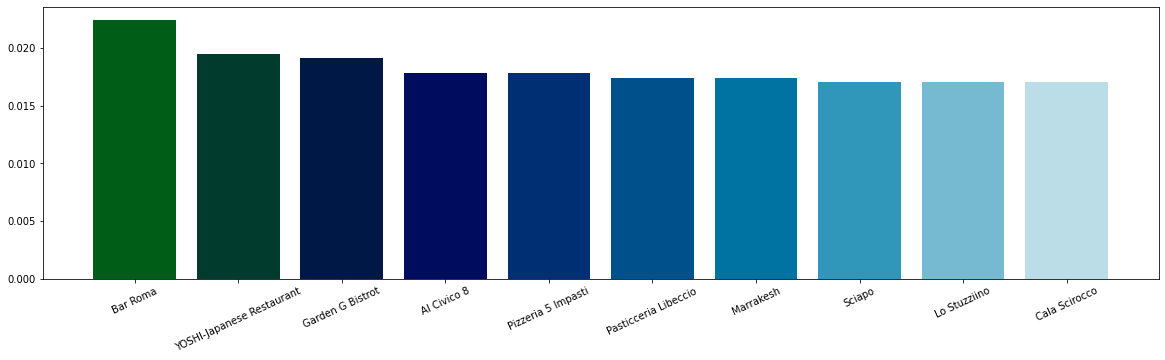

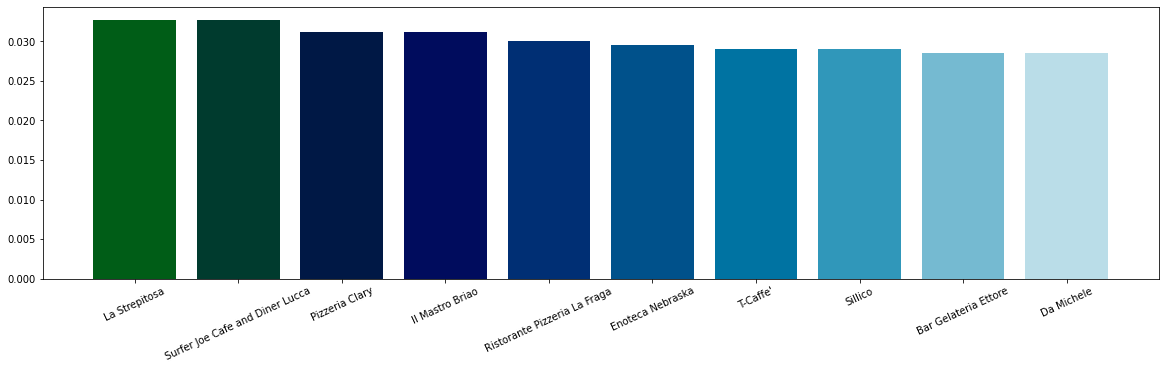

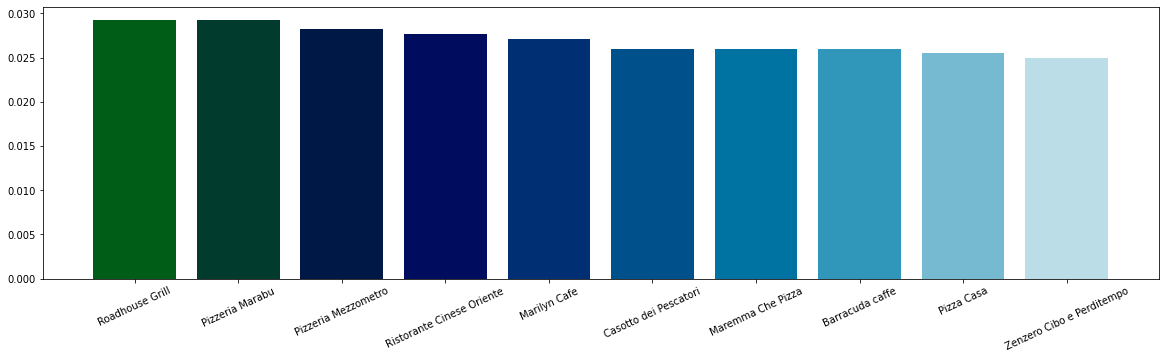

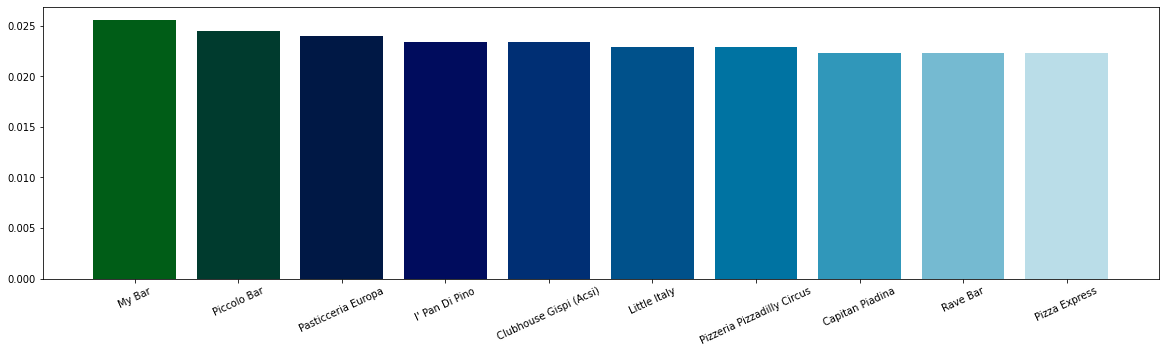

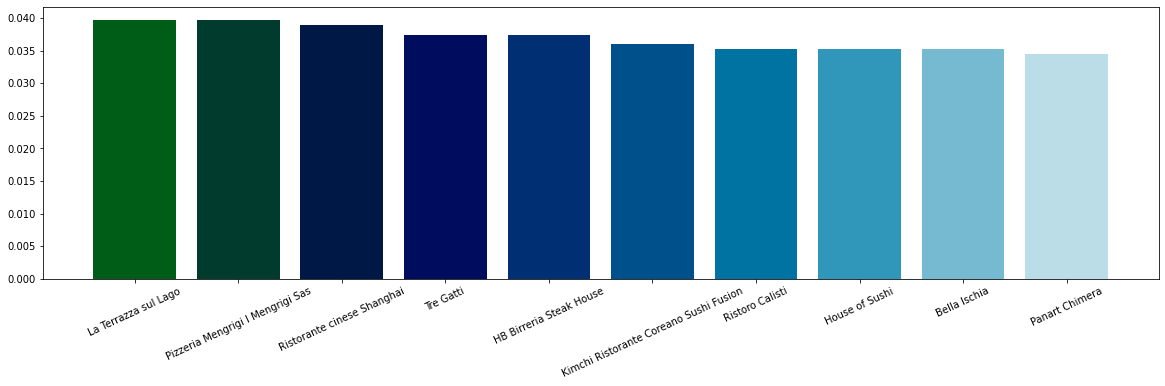

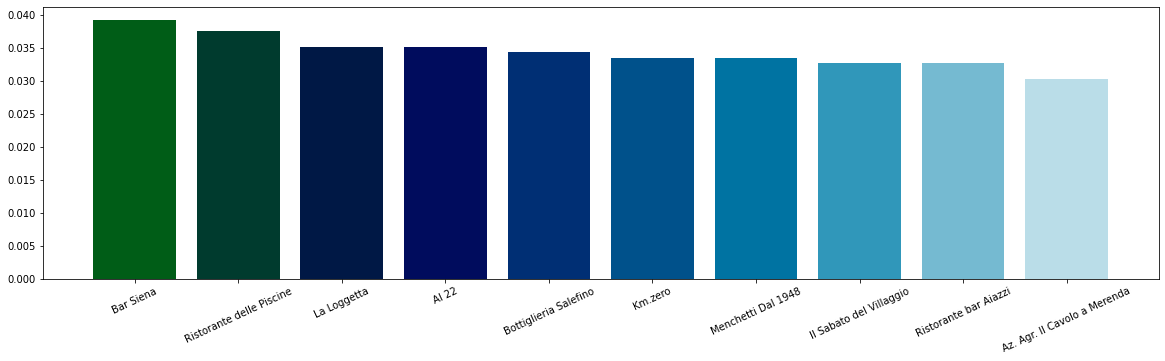

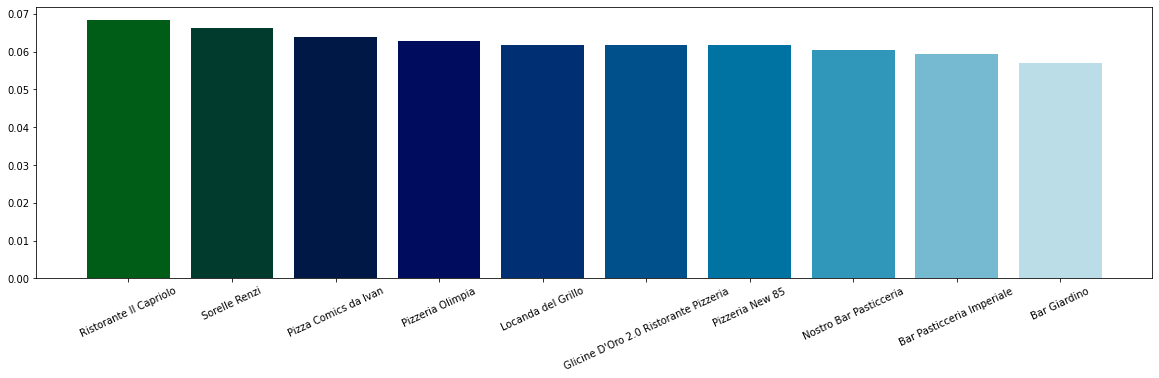

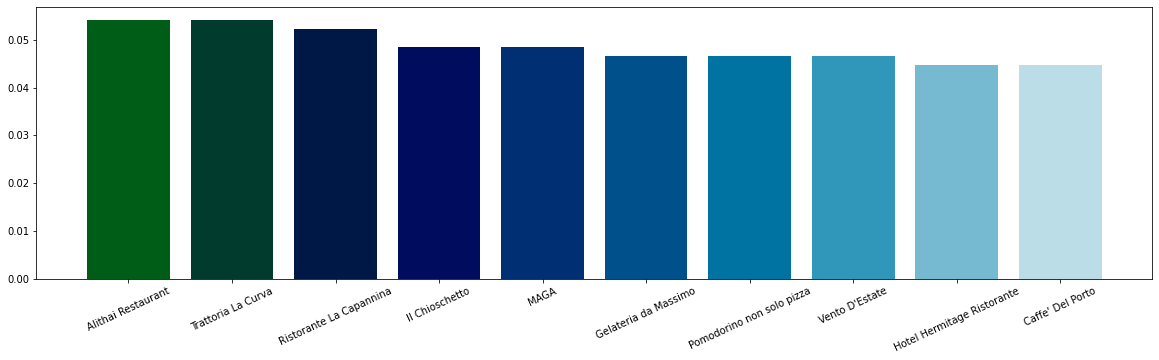

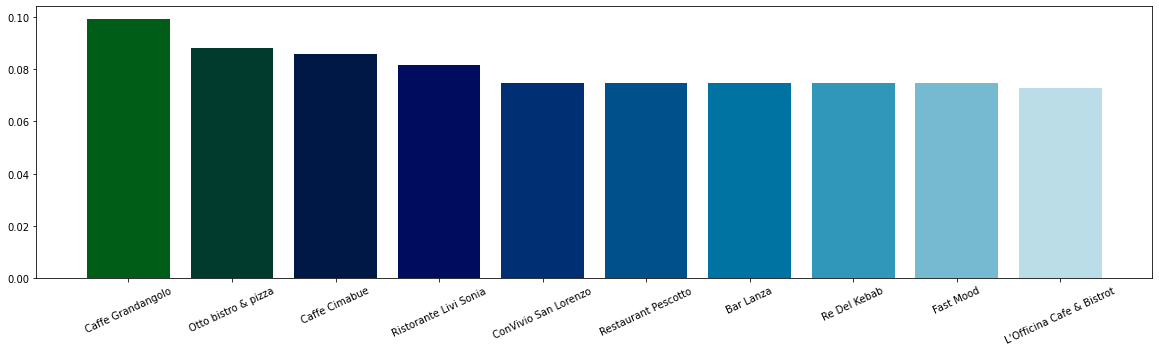

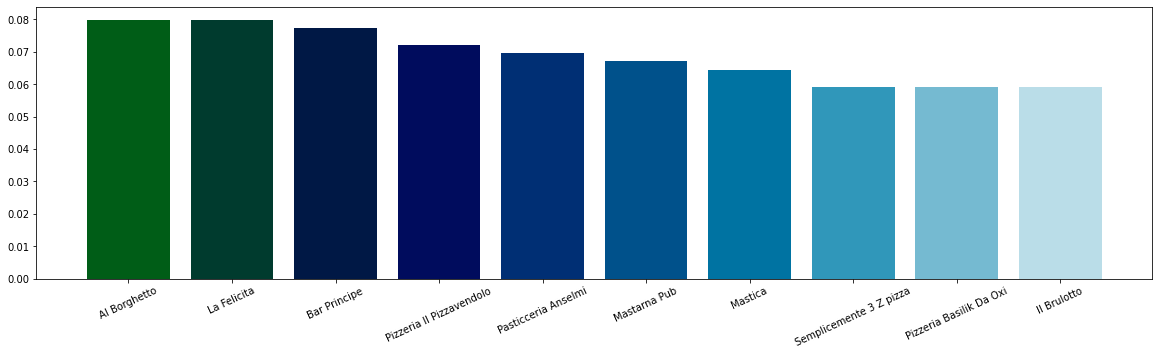

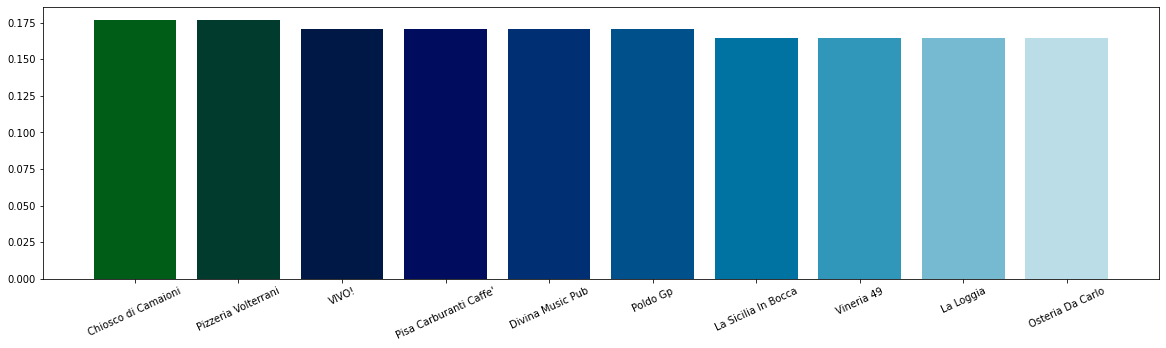

In [12]:
for c in data['louvain'].communities:
    if len(c) <100: continue 
    C = G.subgraph(c).copy()
    degree_centrality = nx.degree_centrality(C)
    plot_kcentral(C,degree_centrality,10)

In [14]:
for i, l in enumerate(data['louvain'].communities):
    for node in l:
        df.loc[node,'louvain'] = i 

In [15]:
pd.crosstab(df['province'],df['louvain'])

louvain,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
province,,,,,,,,,,,,,,,,,
arezzo,10,10,8,27,10,1014,21,1,7,7,6,3,0,0,0,0,0
florence,2014,254,50,99,324,189,119,38,27,362,57,91,7,8,0,6,0
grosseto,29,28,15,1379,24,25,23,5,10,14,14,5,0,0,0,0,0
livorno,57,824,32,34,76,30,19,10,439,12,249,11,2,0,0,0,1
lucca,25,73,1643,32,56,20,16,42,16,6,14,4,0,0,2,0,0
massacarrara,7,12,19,5,12,0,7,727,0,0,1,1,0,0,0,0,0
pisa,138,1145,84,46,31,11,63,27,12,34,17,19,11,0,9,0,0
pistoia,26,33,20,17,822,2,11,5,6,11,11,3,0,0,0,0,0
prato,18,4,5,8,464,2,6,3,6,2,5,10,0,2,0,0,0


In [16]:
for i, l in enumerate(data['async_fluid10'].communities):
    for node in l:
        df.loc[node,'async_fluid10'] = i 

In [17]:
pd.crosstab(df['province'],df['async_fluid10'])

async_fluid10,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
province,,,,,,,,,,
arezzo,10,9,8,216,26,20,17,421,357,40
florence,68,214,319,955,292,247,666,444,274,166
grosseto,8,25,819,56,51,327,36,21,41,187
livorno,50,67,164,62,157,125,104,114,352,601
lucca,1508,69,38,32,53,32,35,26,64,92
massacarrara,22,199,4,4,527,8,13,6,2,6
pisa,51,817,51,88,82,73,66,162,77,180
pistoia,18,93,14,27,108,15,431,80,167,14
prato,19,66,141,26,28,10,48,129,55,13
